## IIIa. Classification models - LGBM - Non-GA

- Use Lazy predict package to explore quickly performance of ML algorithms on task
- Use LGBM classifier to build predictive models for each augmented dataset from non-optimised & optimised CTGAN models
- Use RFE for best feature subset selection
- Use randomised search for hyperparameter tuning with cross-validation
- Use custom PR-AUC function for all model performance evaluation on validation folds and test (hold-out data) datasets in line with project objective
- 'Balanced' dataset (non-optimised) with all features & default hyperparameters is the baseline reference model to compare with the 6 models built using  non-optimised CTGAN samples and the 6 models built using optimised CTGAN samples. Also compare the 12 models when comprising only selected subset of features via RFE wrapper versus all features
- Focus evaluation of models on the threshold invariant metrics of PR/ROC-AUC. The threshold-based metrics use the probability cut-off which balances specificity and sensitivity ('ss'). Exploratory analysis shows that a cut-off based on balancing precision and recall assigns most test samples to positive class giving poor results and the 0.5 cut-off is non-sensical given the priors. Do not know how Tsai et al (2022) and Shih et al (2023) derived their threshold cut-off but assume it is 0.5
- Use the Scikit-learn API for LGBM classifier build as it utilises easy-to-use Scikit-learn methods & enables cross-validation with hyperparameter search which the Train API does now allow

### Contents

1. Set up packages & drives
2. User-defined functions
3. Import & prepare data
4. Get classification models based on different sized-feature subsets for each augmentation scenario
5. Create LGBM classification models using best performing feature subsets & tuned hyperparameters (random search)




### 1. Set up packages & drives

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from numpy import argmax,sqrt
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
from sklearn.metrics import make_scorer,accuracy_score,precision_score,precision_recall_curve,recall_score,f1_score,confusion_matrix,auc,roc_curve,accuracy_score,roc_auc_score,average_precision_score,log_loss
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV,train_test_split,RandomizedSearchCV,cross_val_score
import seaborn as sns
import time
import random
from scipy.stats import randint,uniform
from sklearn.feature_selection import RFE
import pickle

import warnings
warnings.filterwarnings('ignore')

# Get access to Google Drive (run once per session)
drive.mount('/content/drive')

### 2. User-defined functions

In [ ]:
########## Data preparation #########

def data_prep(model_name,train,test):

  ##### Get data #####

  train_df=pd.read_pickle(train)
  test_df=pd.read_pickle(test)

  ##### Standardize data #####

  # Training

  # Get all numeric features for standardization
  features=train_df.drop(['disease1','type'],axis=1)
  # Standardize numeric features
  scaler=MinMaxScaler()
  scaler.fit(features)
  features_std=scaler.transform(features)
  # Combine the standardized features with the target feature
  features_std=pd.DataFrame(features_std, columns=features.columns)
  features_std['disease1']=train_df['disease1']
  train=features_std
  # Make target feature numeric
  train['disease1']=train['disease1'].astype('int64')

  # Test

  test_features=test_df.drop('disease1',axis=1)
  # Standardize numeric features
  test_features_std=scaler.transform(test_features)
  # Combine the scaled features with the target feature
  test_features_std=pd.DataFrame(test_features_std, columns=test_features.columns)
  test_features_std['disease1']=test_df['disease1']
  test=test_features_std
  # Make target feature numeric
  test['disease1']=test['disease1'].astype('int64')

  ##### Split features and labels for model build #####

  x_train=train.drop(['disease1'],axis=1)
  y_train=train['disease1']
  x_test=test.drop(['disease1'],axis=1)
  y_test=test['disease1']

  ##### Check datasets #####

  train_samples=x_train.shape[0]
  train_labels=y_train.shape[0]
  test_samples=x_test.shape[0]
  test_labels=y_test.shape[0]
  all_samples=train_samples+test_samples
  all_labels=train_labels+test_labels
  sizing_dic={model_name:{'train_samples':train_samples,
                          'train_labels':train_labels,
                          'test_samples':test_samples,
                          'test_labels':test_labels,
                          'all_samples':all_samples,
                          'all_labels':all_labels}}

  sizing_df=pd.DataFrame.from_dict(sizing_dic,orient='index')


  return(x_train,y_train,x_test,y_test,sizing_df)

########## Custom model evaluation function ##########

def pr_auc_eval(y_true,y_pred):
    precision,recall,_=precision_recall_curve(y_true, y_pred)
    pr_auc=auc(recall,precision)
    return pr_auc

########## Calculate F1-scores (array) from precision & recall arrays #########

def f1_scores_array(precision, recall):
    # Ensure the arrays are of same length
    assert len(precision)==len(recall), "Arrays must have same length"
    # Set up scores array with default value of 0
    f1_scores=np.zeros(len(precision))
    # Calculate score for each pair of precision & recall values
    for i in range(len(precision)):
        if precision[i]==0 and recall[i]==0:
            f1_scores[i]=0
        else:
            f1_scores[i]=2*(precision[i]*recall[i])/(precision[i]+recall[i])
    return f1_scores

########## Model evaluation ###########

def model_eval(model_name, y_test, y_pred, y_class, feat_names, feat_imp, valid_score, assign_method=None):

  ##### Consider alternative methods for determining optimal threshold cut-off #####

  # Balancing recall & precision - APPEARS TO CLASSIFY ALL CLASSES AS POSITIVE CLASS - DO NOT USE

  if assign_method=='pr':
    precision0, recall0, thresholds=precision_recall_curve(y_test,y_pred)
    f1_scores=f1_scores_array(precision0, recall0)
    # Get optimal threshold
    idx=np.argmax(f1_scores)
    y_class=(y_pred>=thresholds[idx]).astype(int)

  # Balancing sensitivity & specificity

  elif assign_method=='ss':
    fpr0, tpr0, thresholds=roc_curve(y_test,y_pred)
    gmeans=np.sqrt(tpr0*(1-fpr0))
    idx=np.argmax(gmeans)
    y_class=(y_pred>=thresholds[idx]).astype(int)

  # Maximum probability score - default method when no argument included in function call
  else:
     y_class

  ##### Performance metrics on test data #####

  logloss=log_loss(y_test,y_pred)
  accuracy=accuracy_score(y_test,y_class)
  recall=recall_score(y_test,y_class)
  precision=precision_score(y_test,y_class)
  tn,fp,fn,tp=confusion_matrix(y_test,y_class).ravel()
  specificity=tn/(tn+fp) if (tn+fp)!=0 else 0
  f1=f1_score(y_test,y_class)
  pr_auc=average_precision_score(y_test,y_pred)
  roc_auc=roc_auc_score(y_test,y_pred)
  fpr,tpr,_=roc_curve(y_test,y_pred)

  metrics_dic={model_name:{'tp':tp,
                           'tn':tn,
                           'fp':fp,
                           'fn':fn,
                           'logloss':logloss,
                           'accuracy':accuracy,
                           'recall':recall,
                           'precision':precision,
                           'specificity':specificity,
                           'f1_score':f1,
                           'pr_auc':pr_auc,
                           'roc_auc':roc_auc,
                           'valid_score':valid_score}}
  metrics_df=pd.DataFrame.from_dict(metrics_dic,orient='index')

  ##### Feature importance scores #####

  feat_imp_df=pd.DataFrame({'feature':feat_names,'importance':feat_imp})
  feat_imp_df=feat_imp_df.sort_values(by='importance',ascending=False)
  feat_imp_df[model_name]=round(feat_imp_df['importance'].rank(ascending=False),0)
  feat_imp_df.sort_values('feature',ascending=True,inplace=True)
  feat_imp_df.drop(columns=['importance'],axis=1,inplace=True)
  feat_imp_df=feat_imp_df.reset_index(drop=True)

  ##### PR & ROC curve data (threshold invariant) #####

  # PR curve
  precision1,recall1,thresholds=precision_recall_curve(y_test,y_pred)
  random_model=len(y_test[y_test==1])/len(y_test)
  pr_curve_dic={model_name:{'precision':precision1,
                            'recall':recall1,
                            'random_model':random_model,
                            'pr_auc':pr_auc}}
  #pr_curve_df=pd.DataFrame.from_dict(pr_curve_dic,orient='index')

  # ROC curve
  fpr,tpr,_=roc_curve(y_test,y_pred)
  roc_curve_dic={model_name:{'fpr':fpr,
                            'tpr':tpr,
                            'roc_auc':roc_auc}}
  #roc_curve_df=pd.DataFrame.from_dict(roc_curve_dic,orient='index')

  return metrics_df, feat_imp_df, pr_curve_dic, roc_curve_dic

########## Architecture of final LGBM model ##########

def lgbm_model(x_train, y_train, x_test, rounds, cust_eval_func=False):

  # Define hyperparameter grid - based on findings froom Model 3 work
  parameters={'num_leaves': randint(40,50),
              'min_child_samples': randint(20,80),
              'max_depth': randint(2,5),
              'learning_rate': uniform(0.4,0.5),
              'reg_alpha': uniform(0.03,0.04),
              'reg_lambda': uniform(0.02,0.025),
              'n_estimators': randint(115,130+1),
              'colsample_bytree': uniform(0.3,0.9),
              'subsample': uniform(0.5,0.60),
              'subsample_for_bin': randint(1500,2000+1),
              'subsample_freq': randint(2,3+1),
              'min_split_gain': uniform(0.01,0.03),
              'min_child_weight': uniform(0.002,0.004)}

  # Instantiate the LGBM classifier
  clf=lgb.LGBMClassifier()

  # Instantiate RandomisedSearchCV for optimal hyperparameter search

  if cust_eval_func:
    rs=RandomizedSearchCV(clf,
                          parameters,
                          scoring=make_scorer(pr_auc_eval,greater_is_better=True,needs_proba=True),
                          n_iter=rounds,
                          cv=5,
                          n_jobs=-1,
                          verbose=2)

  else:
    rs=RandomizedSearchCV(clf,
                          parameters,
                          scoring='f1',
                          n_iter=rounds,
                          cv=5,
                          n_jobs=-1,
                          verbose=2)

  # Perform the random search and train the model
  rs.fit(x_train,y_train)

  # Get best model
  best_model=rs.best_estimator_

  # Get best (mean) validation score
  valid_score=rs.best_score_

  # Get hyperparameters of best model
  hypers=rs.best_params_

  # Get probability scores & class assignments for test data
  y_pred=best_model.predict_proba(x_test)[:, 1]
  y_class=best_model.predict(x_test)

  # Get feature importance scores (based on gain & not split)
  feat_names=x_train.columns.tolist()
  feat_imp=best_model.booster_.feature_importance(importance_type='gain')

  return y_pred, y_class, feat_names, feat_imp, best_model, hypers, valid_score

########## RFE feature selection ##########

##### NEED TO CHANGE THIS AS USING TEST DATA AND MAY CAUSE LEAKAGE!!! SEE CODE BELOW #####

# Not using CV here due to resource restrictions

def feat_sel(x_train, y_train, x_test, y_test, aug_scen_name):

  # Instantiate a LightGBM classifier with default features
  clf=lgb.LGBMClassifier(verbose=-1)

  # Create a dictionary for results for each iteration of 'num_feats' (to retain)
  results={}

  # Find performance of LGBM based on different sized selections of features (1 to 36)
  for num_feats in range(1,37):

      # Instantiate the RFE on LGBM & number of features
      rfe=RFE(estimator=clf, n_features_to_select=num_feats)

      # Fit RFE to training data
      rfe.fit(x_train, y_train)

      # Get selected features
      sel_feats=x_train.columns[rfe.support_]

      # Transform train & test datasets to include only selected features - these are arrays
      x_train_t=rfe.transform(x_train)
      x_test_t=rfe.transform(x_test)

      # Train LGBM model on training dataset with only selected features
      clf.fit(x_train_t, y_train)

      # Get probability scores & class assignments for test data
      y_pred=clf.predict_proba(x_test_t)[:, 1]
      y_class=clf.predict(x_test_t)

      # Get performance metrics
      pr_auc=average_precision_score(y_test,y_pred)
      roc_auc=roc_auc_score(y_test,y_pred)

      # Get hyperparameters
      hypers=clf.get_params()

      # Get feature importance scores based on gain & not split
      # feature_importance.() returns scores in same order as features in training data
      feat_names=sel_feats
      feat_imp=clf.booster_.feature_importance(importance_type='gain')

      # Store metrics of each model in the results dictionary
      results[num_feats]={'num_feats':len(sel_feats),
                          'pr_auc':pr_auc,
                          'roc_auc':roc_auc,
                          'hypers':hypers,
                          'sel_feats':sel_feats,
                          'feat_names':feat_names,
                          'feat_imp':feat_imp,
                          'y_pred':y_pred,
                          'y_class':y_class}

  # Convert results dictionary into a DataFrame & reformat
  results_df=pd.DataFrame(results)
  results_df_t=results_df.T
  results_df_t['num_feats']=results_df_t['num_feats'].astype('int64')
  results_df_t[['pr_auc','roc_auc']]=results_df_t[['pr_auc','roc_auc']].astype('float64')

  # Get best model as a dictionary
  best_pr_auc_idx=results_df_t['pr_auc'].idxmax()
  best_model=results_df_t.loc[best_pr_auc_idx].to_dict()

  # Get model with all features as a dictionary
  all_feats_model=results_df_t.loc[36].to_dict()

  return best_model, all_feats_model

##### POSSIBLE FIX #####

# def feat_sel(x_train, y_train, test_size=0.2):
#     # Split the training data into training and validation sets
#     x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=test_size, random_state=42)

#     # Instantiate a LightGBM classifier with default features
#     clf = lgb.LGBMClassifier(verbose=-1)

#     # Create a dictionary for results for each iteration of 'num_feats' (to retain)
#     results = {}

#     # Find performance of LGBM based on different sized selections of features (1 to 36)
#     for num_feats in range(1, 37):
#         # Instantiate the RFE on LGBM & number of features
#         rfe = RFE(estimator=clf, n_features_to_select=num_feats)

#         # Fit RFE to training data
#         rfe.fit(x_train, y_train)

#         # Get selected features
#         sel_feats = x_train.columns[rfe.support_]

#         # Transform validation dataset to include only selected features
#         x_val_t = x_val[sel_feats]

#         # Train LGBM model on training dataset with only selected features
#         clf.fit(x_train, y_train)

#         # Get probability scores & class assignments for validation data
#         y_pred = clf.predict_proba(x_val_t)[:, 1]

#         # Get performance metrics
#         pr_auc = average_precision_score(y_val, y_pred)
#         roc_auc = roc_auc_score(y_val, y_pred)

#         # Get hyperparameters
#         hypers = clf.get_params()

#         # Get feature importance scores based on gain
#         feat_imp = clf.booster_.feature_importance(importance_type='gain')

#         # Store metrics of each model in the results dictionary
#         results[num_feats] = {'num_feats': len(sel_feats),
#                               'pr_auc': pr_auc,
#                               'roc_auc': roc_auc,
#                               'hypers': hypers,
#                               'sel_feats': sel_feats,
#                               'feat_imp': feat_imp,
#                               'y_pred': y_pred}

#     # Convert results dictionary into a DataFrame & reformat
#     results_df = pd.DataFrame(results)
#     results_df_t = results_df.T
#     results_df_t['num_feats'] = results_df_t['num_feats'].astype('int64')
#     results_df_t[['pr_auc', 'roc_auc']] = results_df_t[['pr_auc', 'roc_auc']].astype('float64')

#     # Get best model as a dictionary
#     best_pr_auc_idx = results_df_t['pr_auc'].idxmax()
#     best_model = results_df_t.loc[best_pr_auc_idx].to_dict()

#     return best_model


########## Feature ranks heatmap ##########

def feat_map(title):

  # Get data
  feat_imp_all = pd.concat([feat_imp_bal, feat_imp_25, feat_imp_50, feat_imp_100, feat_imp_250, feat_imp_500, feat_imp_1000], axis=1).iloc[:,[0,1,3,5,7,9,11,13]].sort_values(by='_bal').reset_index(drop=True)

  # Categorising of values e.g. values 1, 2, 3, 4, 5 are set to 5
  def replace_values(value):
      replacement_values={ 1:5,   2:5,   3:5,   4:5,   5:5,
                          6:10,  7:10,  8:10,  9:10, 10:10,
                          11:15, 12:15, 13:15, 14:15, 15:15,
                          16:20, 17:20, 18:20, 19:20, 20:20,
                          21:30, 22:30, 23:30, 24:30, 25:30,
                          26:30, 27:30, 28:30, 29:30, 30:30,
                          31:36, 32:36, 33:36, 34:36, 35:36,
                          36:36}
      return replacement_values.get(value,value)

  df1 = feat_imp_all.applymap(replace_values)

  # Reshape for heatmap
  melt_df1 = pd.melt(df1, id_vars=['feature'], var_name='Model', value_name='Rank')

  # Specify order of models
  custom_model_order=['_bal','_25','_50','lgbm_100','_250','_500','_1000']

  # Convert 'Model' column to Categorical with custom order
  melt_df1['Model'] = pd.Categorical(melt_df1['Model'], categories=custom_model_order, ordered=True)

  # Sort the dataframe & pivot
  melt_df1 = melt_df1.sort_values(by=['feature','Model'])
  melt_df1.rename(columns={'feature':'Feature'}, inplace=True)
  heatmap_data=melt_df1.pivot(index='Feature', columns='Model', values='Rank')

  # Plot heat map
  plt.figure(figsize=(12,8))
  colors = sns.color_palette("viridis_r", as_cmap=True)
  heatmap = sns.heatmap(heatmap_data, cmap=colors, annot=True, fmt="g", cbar=False)
  plt.title('Feature importance ranks by model' + '\n' + title)
  heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=9)
  heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=9)
  heatmap.set_xlabel(heatmap.get_xlabel(),fontsize=11)
  heatmap.set_ylabel(heatmap.get_ylabel(),fontsize=11)

  plt.show()

  return

########## Feature ranks heatmap (version 2) ##########

def feat_heatmap(df, title, x, y, opt_flag=None):
  # Flag informs the function if the CTGAN was optimsed or not

  # Sort data
  df1=df.sort_values(by=df.columns[0]).reset_index(drop=True)

  # Replace NaN with 99 (='not used by model')
  df2=df1.fillna(99)

  # Group the ranks for easier interpretation e.g. values 1, 2, 3, 4, 5 are set to 5

  def replace_values(value):

      replacement_values={ 1:5,   2:5,   3:5,   4:5,   5:5,
                          6:10,  7:10,  8:10,  9:10, 10:10,
                          11:15, 12:15, 13:15, 14:15, 15:15,
                          16:20, 17:20, 18:20, 19:20, 20:20,
                          21:25, 22:25, 23:25, 24:25, 25:25,
                          26:30, 27:30, 28:30, 29:30, 30:30,
                          31:35, 32:35, 33:35, 34:35, 35:35,
                          36:40,
                          99:99}

      return replacement_values.get(value,value)

  df3=df2.applymap(replace_values)

  # Reshape data for heatmap
  df4=pd.melt(df3, id_vars=['feature'], var_name='Model', value_name='Rank')

  # Specify order of models
  if opt_flag==1:
    custom_model_order=['_25_o','_50_o','_100_o','_250_o','_500_o','_1000_o']
  else:
    custom_model_order=['_bal','_25','_50','_100','_250','_500','_1000']

  # Convert 'Model' column to Categorical with custom order
  df4['Model']=pd.Categorical(df4['Model'], categories=custom_model_order, ordered=True)

  # Sort the dataframe & pivot
  df5=df4.sort_values(by=['feature','Model'])
  df5.rename(columns={'feature':'Feature'}, inplace=True)

  heatmap_data=df5.pivot(index='Feature', columns='Model', values='Rank')

  # Plot heat map
  colors = sns.color_palette("viridis_r", as_cmap=True)
  heatmap = sns.heatmap(heatmap_data, cmap=colors, annot=True, fmt="g", cbar=False, ax=axes[x, y])
  heatmap.set_title(title)
  heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=9)
  heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=9)
  heatmap.set_xlabel(heatmap.get_xlabel(),fontsize=11)
  heatmap.set_ylabel(heatmap.get_ylabel(),fontsize=11)

  return

########## Plotting PR & ROC curves ##########

def pr_roc_curves(title):

  plt.figure(figsize=(16, 5))

  ##### PR curve #####

  plt.subplot(1, 2, 1)

  # Random model (same for all augmentation scenarios)
  plt.plot([0, 1],[pr_curve_dic_bal['_bal']['random_model'],pr_curve_dic_bal['_bal']['random_model']], linestyle='--',color='gray',label='Random model')

  # bal
  pr_auc_bal=pr_curve_dic_bal['_bal']['pr_auc']
  plt.plot(pr_curve_dic_bal['_bal']['recall'],pr_curve_dic_bal['_bal']['precision'],label=f'Bal - AUC={pr_auc_bal:.2f}')#,color='magenta')
  # 25%
  pr_auc_25=pr_curve_dic_25['_25']['pr_auc']
  plt.plot(pr_curve_dic_25['_25']['recall'],pr_curve_dic_25['_25']['precision'],label=f'+25% - AUC={pr_auc_25:.2f}')#,color='cyan')
  # 50%
  pr_auc_50=pr_curve_dic_50['_50']['pr_auc']
  plt.plot(pr_curve_dic_50['_50']['recall'],pr_curve_dic_50['_50']['precision'],label=f'+50% - AUC={pr_auc_50:.2f}')#,color='lightblue')
  # 100%
  pr_auc_100=pr_curve_dic_100['_100']['pr_auc']
  plt.plot(pr_curve_dic_100['_100']['recall'],pr_curve_dic_100['_100']['precision'],label=f'+100% - AUC={pr_auc_100:.2f}')#,color='lightblue')
  # 250%
  pr_auc_250=pr_curve_dic_250['_250']['pr_auc']
  plt.plot(pr_curve_dic_250['_250']['recall'],pr_curve_dic_250['_250']['precision'],label=f'+250% - AUC={pr_auc_250:.2f}')#,color='lightblue')
  # 500%
  pr_auc_500=pr_curve_dic_500['_500']['pr_auc']
  plt.plot(pr_curve_dic_500['_500']['recall'],pr_curve_dic_500['_500']['precision'],label=f'+500% - AUC={pr_auc_500:.2f}')#,color='lightblue')
  # 1,000%
  pr_auc_1000=pr_curve_dic_1000['_1000']['pr_auc']
  plt.plot(pr_curve_dic_1000['_1000']['recall'],pr_curve_dic_1000['_1000']['precision'],label=f'+1000% - AUC={pr_auc_1000:.2f}')#,color='lightblue')

  plt.xlabel('Recall',fontsize=9)
  plt.xticks(fontsize=8)
  plt.ylabel('Precision',fontsize=9)
  plt.yticks(fontsize=8)
  plt.ylim(0.75,1.0)
  plt.title('PR curve - LGBM model - By augmented dataset' + '\n' + title, fontsize=10)
  plt.legend(loc='upper right',fontsize=7,frameon=False)

  ##### ROC curve #####

  plt.subplot(1, 2, 2)

  # Random model (same for all augmentation scenarios)
  plt.plot([0, 1], [0, 1],linestyle='--', color='gray',label='Random model')

  # bal
  roc_auc_bal=roc_curve_dic_bal['_bal']['roc_auc']
  plt.plot(roc_curve_dic_bal['_bal']['fpr'],roc_curve_dic_bal['_bal']['tpr'],label=f'Bal - AUC={roc_auc_bal:.2f}')#,color='magenta')
  # 25%
  roc_auc_25=roc_curve_dic_25['_25']['roc_auc']
  plt.plot(roc_curve_dic_25['_25']['fpr'],roc_curve_dic_25['_25']['tpr'],label=f'+25% - AUC={roc_auc_25:.2f}')#,color='cyan')
  # 50%
  roc_auc_50=roc_curve_dic_50['_50']['roc_auc']
  plt.plot(roc_curve_dic_50['_50']['fpr'],roc_curve_dic_50['_50']['tpr'],label=f'+50% - AUC={roc_auc_50:.2f}')#,color='lightblue')
  # 100%
  roc_auc_100=roc_curve_dic_100['_100']['roc_auc']
  plt.plot(roc_curve_dic_100['_100']['fpr'],roc_curve_dic_100['_100']['tpr'],label=f'+100% - AUC={roc_auc_100:.2f}')#,color='lightblue')
  # 250%
  roc_auc_250=roc_curve_dic_250['_250']['roc_auc']
  plt.plot(roc_curve_dic_250['_250']['fpr'],roc_curve_dic_250['_250']['tpr'],label=f'+250% - AUC={roc_auc_250:.2f}')#,color='lightblue')
  # 500%
  roc_auc_500=roc_curve_dic_500['_500']['roc_auc']
  plt.plot(roc_curve_dic_500['_500']['fpr'],roc_curve_dic_500['_500']['tpr'],label=f'+500% - AUC={roc_auc_500:.2f}')#,color='lightblue')
  # 1,000%
  roc_auc_1000=roc_curve_dic_1000['_1000']['roc_auc']
  plt.plot(roc_curve_dic_1000['_1000']['fpr'],roc_curve_dic_1000['_1000']['tpr'],label=f'+1000% - AUC={roc_auc_1000:.2f}')#,color='lightblue')

  plt.xlabel('False Positive Rate (FPR)',fontsize=9)
  plt.xticks(fontsize=8)
  plt.ylabel('True Positive Rate (TPR)',fontsize=9)
  plt.yticks(fontsize=8)
  plt.ylim(0.0,1.0)
  plt.title('ROC curve - LGBM model - By augmented dataset' + '\n' + title, fontsize=10)
  plt.legend(loc='lower right',fontsize=7,frameon=False)

  plt.show()

  return

########## Plotting PR & ROC curves (version 2) ##########

def auc_curves1(# PR curve
                best_pr1,   best_pr2,
                all_pr1,    all_pr2,
                # ROC curve
                best_roc1,  best_roc2,
                all_roc1,   all_roc2,
                # title
                title,
                # Subplot positions - row=i, col0=j, col1=k
                i,j,k):

  ########## PR curve ##########

  # Best subset of features
  # Non-optimised CTGAN
  pr_auc_best_feats=best_pr1['pr_auc']
  axes[i,j].plot(best_pr1['recall'],best_pr1['precision'],label=f'Best feats - AUC - CTGAN non-opt={pr_auc_best_feats:.2f}',color='magenta')
  # Optimised CTGAN
  pr_auc_best_feats=best_pr2['pr_auc']
  axes[i,j].plot(best_pr2['recall'],best_pr2['precision'],label=f'Best feats - AUC - CTGAN opt={pr_auc_best_feats:.2f}',color='magenta',linestyle=':')

  # All features
  # Non-optimised CTGAN
  pr_auc_all_feats=all_pr1['pr_auc']
  axes[i,j].plot(all_pr1['recall'],all_pr1['precision'],label=f'All feats - AUC - CTGAN non-opt={pr_auc_all_feats:.2f}',color='cyan')
  # Optimised CTGAN
  pr_auc_all_feats=all_pr2['pr_auc']
  axes[i,j].plot(all_pr2['recall'],all_pr2['precision'],label=f'All feats - AUC - CTGAN opt={pr_auc_all_feats:.2f}',color='cyan',linestyle=':')

  # Random model (same for all augmentation scenarios)
  axes[i,j].plot([0, 1],[best_pr1['random_model'],best_pr1['random_model']], linestyle='--',color='gray',label='Random model')

  axes[i,j].set_xlabel('Recall',fontsize=10)
  axes[i,j].tick_params(axis='x',labelsize=10)
  axes[i,j].set_ylabel('Precision',fontsize=10)
  axes[i,j].tick_params(axis='y',labelsize=10)
  axes[i,j].set_ylim(0.75,1.01)
  axes[i,j].set_title(title+' - PR curve',fontsize=11)
  axes[i,j].legend(loc='upper right',fontsize=7,frameon=False)

  ########## ROC curve ##########

  # Best subset of features
  # Non-optimised CTGAN
  roc_auc_best_feats=best_roc1['roc_auc']
  axes[i,k].plot(best_roc1['fpr'],best_roc1['tpr'],label=f'Best feats - AUC - CTGAN non-opt={roc_auc_best_feats:.2f}',color='magenta')
  # Optimised CTGAN
  roc_auc_best_feats=best_roc2['roc_auc']
  axes[i,k].plot(best_roc2['fpr'],best_roc2['tpr'],label=f'Best feats - AUC - CTGAN opt={roc_auc_best_feats:.2f}',color='magenta',linestyle=':')

  # All features
  # Non-optimised CTGAN
  roc_auc_all_feats=all_roc1['roc_auc']
  axes[i,k].plot(all_roc1['fpr'],all_roc1['tpr'],label=f'All feats - AUC - CTGAN non-opt={roc_auc_all_feats:.2f}',color='cyan')
  # Optimised CTGAN
  roc_auc_all_feats=all_roc2['roc_auc']
  axes[i,k].plot(all_roc2['fpr'],all_roc2['tpr'],label=f'All feats - AUC - CTGAN opt={roc_auc_all_feats:.2f}',color='cyan',linestyle=':')

  # Random model (same for all augmentation scenarios)
  axes[i,k].plot([0, 1], [0, 1],linestyle='--', color='gray',label='Random model')


  axes[i,k].set_xlabel('False Positive Rate (FPR)',fontsize=10)
  axes[i,k].tick_params(axis='x',labelsize=10)
  axes[i,k].set_ylabel('True Positive Rate (TPR)',fontsize=10)
  axes[i,k].tick_params(axis='y',labelsize=10)
  axes[i,k].set_ylim(0.0,1.01)
  axes[i,k].set_title(title+' - ROC curve', fontsize=11)
  axes[i,k].legend(loc='lower right',fontsize=7,frameon=False)

  return

  ########## Plotting PR & ROC curves (version 3) ##########

def auc_curves2(# PR curve
                best_pr1,   best_pr2,
                # ROC curve
                best_roc1,  best_roc2,
                # title
                title,
                # Subplot positions - row=i, col0=j, col1=k
                i,j,k):

  ########## PR curve ##########

  # Best subset of features
  # Non-optimised CTGAN
  pr_auc_best_feats=best_pr1['pr_auc']
  axes[i,j].plot(best_pr1['recall'],best_pr1['precision'],label=f'Best feats - AUC - CTGAN non-opt={pr_auc_best_feats:.2f}',color='magenta')
  # Optimised CTGAN
  pr_auc_best_feats=best_pr2['pr_auc']
  axes[i,j].plot(best_pr2['recall'],best_pr2['precision'],label=f'Best feats - AUC - CTGAN opt={pr_auc_best_feats:.2f}',color='magenta',linestyle=':')

  # Random model (same for all augmentation scenarios)
  axes[i,j].plot([0, 1],[best_pr1['random_model'],best_pr1['random_model']], linestyle='--',color='gray',label='Random model')

  axes[i,j].set_xlabel('Recall',fontsize=10)
  axes[i,j].tick_params(axis='x',labelsize=10)
  axes[i,j].set_ylabel('Precision',fontsize=10)
  axes[i,j].tick_params(axis='y',labelsize=10)
  axes[i,j].set_ylim(0.75,1.01)
  axes[i,j].set_title(title+' - PR curve',fontsize=11)
  axes[i,j].legend(loc='upper right',fontsize=7,frameon=False)

  ########## ROC curve ##########

  # Best subset of features
  # Non-optimised CTGAN
  roc_auc_best_feats=best_roc1['roc_auc']
  axes[i,k].plot(best_roc1['fpr'],best_roc1['tpr'],label=f'Best feats - AUC - CTGAN non-opt={roc_auc_best_feats:.2f}',color='magenta')
  # Optimised CTGAN
  roc_auc_best_feats=best_roc2['roc_auc']
  axes[i,k].plot(best_roc2['fpr'],best_roc2['tpr'],label=f'Best feats - AUC - CTGAN opt={roc_auc_best_feats:.2f}',color='magenta',linestyle=':')

  # Random model (same for all augmentation scenarios)
  axes[i,k].plot([0, 1], [0, 1],linestyle='--', color='gray',label='Random model')


  axes[i,k].set_xlabel('False Positive Rate (FPR)',fontsize=10)
  axes[i,k].tick_params(axis='x',labelsize=10)
  axes[i,k].set_ylabel('True Positive Rate (TPR)',fontsize=10)
  axes[i,k].tick_params(axis='y',labelsize=10)
  axes[i,k].set_ylim(0.0,1.01)
  axes[i,k].set_title(title+' - ROC curve', fontsize=11)
  axes[i,k].legend(loc='lower right',fontsize=7,frameon=False)

  return

########## LGBM classifier using random search for hyperparameters ##########

def lgbm_model(eval_metric, feats, n_iter, x_train, y_train, x_test, y_test):

  # Initial grid with broader values (defaults in brackets)

  # search_grid={'num_leaves':         randint(2,50+1),       # 31
  #              'min_child_samples':  randint(15,100+1),     # 20
  #              'max_depth':          randint(1,20+1),       # -1 (no max)
  #              'learning_rate':      uniform(0.005,0.5),    # 0.1
  #              'reg_alpha':          uniform(0,0.05),       # 0.0
  #              'reg_lambda':         uniform(0,0.05),       # 0.0
  #              'n_estimators':       randint(25,150+1),     # 100
  #              'colsample_bytree':   uniform(0.3,1.0),      # 1.0
  #              'subsample':          uniform(0.5,1.0),      # 1.0
  #              'subsample_for_bin':  randint(1000,6500+1),  # 200000
  #              'subsample_freq':     randint(0,5+1),        # 0
  #              'min_split_gain':     uniform(0.001,0.05),   # 0.0
  #              'min_child_weight':   uniform(0.001,0.1)}    # 0.001

  # Narrower grid with values closer to default values (except subsample_for_bin) (defaults in brackets)

  search_grid={'num_leaves':         randint(5,60+1),       # 31
               'min_child_samples':  randint(5,60+1),       # 20
               'max_depth':          randint(1,15+1),       # -1 (no max)
               'learning_rate':      uniform(0.01,0.15),    # 0.1
               'reg_alpha':          uniform(0,0.05),       # 0.0
               'reg_lambda':         uniform(0,0.05),       # 0.0
               'n_estimators':       randint(80,120+1),     # 100
               'colsample_bytree':   uniform(0.8,1.0),      # 1.0
               'subsample':          uniform(0.7,1.0),      # 1.0
               #'subsample_for_bin':  randint(30,500+1),     # 200000
               'subsample_for_bin':  randint(1000,6500+1),  # 200000
               'subsample_freq':     randint(0,3+1),        # 0
               'min_split_gain':     uniform(0.001,0.02),   # 0.0
               'min_child_weight':   uniform(0.001,0.005)}  # 0.001

  # Instantiate the LGBM classifier
  clf=lgb.LGBMClassifier(verbose=0) # '-1' removes all output

  # Instantiate RandomisedSearchCV for optimal hyperparameter search using cross-validation
  rs=RandomizedSearchCV(estimator=clf,
                        param_distributions=search_grid,
                        scoring=eval_metric,
                        n_iter=n_iter,
                        cv=5,
                        n_jobs=-1,
                        verbose=0)  # '-1' removes all output

  # Notes:
  # 1. As the objective function is 'binary' the default evaluation function used in each run of the CV is 'binary_logloss'
  # 2. To use a different in-built evaluation function use 'scoring=' e.g. scoring='roc_auc' (quotes required)
  #    To use a custom evaluation function use 'make_scorer' which overrides in-built functions (no quote marks required around name of custom function)
  # 3. 'n_iter' is the number of (random) selections of hyperparameters from the grid per fold
  # 4. StratifiedKFold is actually used by default here
  # 5. Use all available cores with n_jobs=-1, but this may be irrelevant when run virtually on Colab

  # Perform the random search and train the model
  rs.fit(x_train[feats], y_train)

  # Get best model
  best_model=rs.best_estimator_

  # Get best (mean) validation score
  valid_score=rs.best_score_

  # Get hyperparameters of best model
  hypers=rs.best_params_

  # Get probability scores & class assignments for test data (max prob method)
  y_pred=best_model.predict_proba(x_test[feats])[:, 1]
  y_class=best_model.predict(x_test[feats])

  # Get feature importance scores (based on gain & not split)
  feat_names=x_test[feats].columns.tolist()
  feat_imp=best_model.booster_.feature_importance(importance_type='gain')

  return y_pred, y_class, feat_names, feat_imp, best_model, hypers, valid_score

### 3. Import & prepare data

- Imports training dataset and test datasets
- Standardizes training & transforms test
- Check sizes of datasets

In [ ]:
# Baseline dataset (balanced using non-optimised CTGAN)
x_train_bal,  y_train_bal,  x_test_bal,  y_test_bal,  sizing_bal  = data_prep('_bal',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_balu.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')

# Dataset augmented using unoptimised CTGAN
x_train_25,   y_train_25,   x_test_25,   y_test_25,   sizing_25   = data_prep('_25',   '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_25u.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_50,   y_train_50,   x_test_50,   y_test_50,   sizing_50   = data_prep('_50',   '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_50u.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_100,  y_train_100,  x_test_100,  y_test_100,  sizing_100  = data_prep('_100',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_100u.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_250,  y_train_250,  x_test_250,  y_test_250,  sizing_250  = data_prep('_250',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_250u.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_500,  y_train_500,  x_test_500,  y_test_500,  sizing_500  = data_prep('_500',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_500u.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_1000, y_train_1000, x_test_1000, y_test_1000, sizing_1000 = data_prep('_1000', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_1000u.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
#                                                                                                                                          Suffix 'u'='unoptimised'

# Dataset augmented using optimised CTGAN
x_train_25_o,   y_train_25_o,   x_test_25_o,   y_test_25_o,   sizing_25_o   = data_prep('_25_o',   '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_25.pkl',   '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_50_o,   y_train_50_o,   x_test_50_o,   y_test_50_o,   sizing_50_o   = data_prep('_50_o',   '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_50.pkl',   '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_100_o,  y_train_100_o,  x_test_100_o,  y_test_100_o,  sizing_100_o  = data_prep('_100_o',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_100.pkl',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_250_o,  y_train_250_o,  x_test_250_o,  y_test_250_o,  sizing_250_o  = data_prep('_250_o',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_250.pkl',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_500_o,  y_train_500_o,  x_test_500_o,  y_test_500_o,  sizing_500_o  = data_prep('_500_o',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_500.pkl',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_1000_o, y_train_1000_o, x_test_1000_o, y_test_1000_o, sizing_1000_o = data_prep('_1000_o', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_1000.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
# Suffix 'o'='optimised'

Check sizes

In [ ]:
sizing_all=pd.concat([sizing_bal,sizing_25,sizing_25_o,sizing_50,sizing_50_o,sizing_100,sizing_100_o,sizing_250,sizing_250_o,sizing_500,sizing_500_o,sizing_1000,sizing_1000_o],ignore_index=False)
sizing_all

### 4. Get classification models based on different sized-feature subsets for each augmentation scenario
- Investigate ML algorithm performance on data using Lazy Predict package
- Use RFE wrapper to identify the best feature subset
- Evaluation metric for each subset is PR-AUC in line with the project objective
- Consider datasets augmented by non-optimised and optimised CTGANs
- LGBM classifier with default hyperparameters is used as it is the classifier to be used in final model build
- Not using cross-validation in RFE wrapper due to high level of computation time required
- ROC-AUC may improve alongside PR-AUC but there isn't a causal relationship
- While the evaluation focus is on threshold invariant metrics (PR/ROC-AUC) exploratory work showed that the derivation of threshold-based performance metrics is more robust and reliable using the threshold which balances sensitivity and specificity ('ss'). Thresholds based on balancing precision and recall or 0.5 showed inconsistent performance which are most probably due to the distribution and spread of probability scores produced by the models

#### 4.05 Lazy learner - Comparison of vanilla models to see what type of model performs better on raw data run

- Investigate the performance of different ML algorithms on the data to get an idea of which ones to use. Literature recommends LGBM
- LGBM performs well here

##### 4.05.1 Non-balanced (raw) data

In [ ]:
# Get cleaned training data
df_imp=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_imp.pkl')
x_train=df_imp.drop(columns=['disease1'])
y_train=df_imp['disease1']
# Get cleaned test data
df_test=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp.pkl')
x_test=df_test.drop(columns=['disease1'])
y_test=df_test['disease1']

# Note that all features are float64 format

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(477, 36)
(477,)
(258, 36)
(258,)


In [ ]:
# Run the lazy predicter
clf = LazyClassifier(custom_metric=pr_auc_eval, verbose=0, ignore_warnings=True)
models, predictions = clf.fit(x_train, x_test, y_train, y_test)
models

100%|██████████| 29/29 [00:03<00:00,  9.18it/s]

[LightGBM] [Info] Number of positive: 380, number of negative: 97
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1685
[LightGBM] [Info] Number of data points in the train set: 477, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796646 -> initscore=1.365460
[LightGBM] [Info] Start training from score 1.365460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,pr_auc_eval,Time Taken
Model,,,,,,
BaggingClassifier,0.79,0.59,0.59,0.78,0.92,0.13
PassiveAggressiveClassifier,0.70,0.59,0.59,0.72,0.91,0.04
NearestCentroid,0.58,0.58,0.58,0.63,0.89,0.05
AdaBoostClassifier,0.79,0.57,0.57,0.77,0.91,0.25
XGBClassifier,0.80,0.56,0.56,0.77,0.91,0.14
LGBMClassifier,0.80,0.56,0.56,0.77,0.91,0.13
Perceptron,0.69,0.56,0.56,0.71,0.90,0.04
BernoulliNB,0.78,0.55,0.55,0.75,0.91,0.03
ExtraTreeClassifier,0.71,0.54,0.54,0.72,0.90,0.03


##### 4.05.2. Balanced data

In [ ]:
# Baseline dataset (balanced using non-optimised CTGAN)
x_train_bal,  y_train_bal,  x_test_bal,  y_test_bal,  sizing_bal  = data_prep('_bal',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_balu.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
# Note that all features are float64 format

In [ ]:
print(x_train_bal.shape)
print(y_train_bal.shape)
print(x_test_bal.shape)
print(y_test_bal.shape)


(770, 36)
(770,)
(258, 36)
(258,)


In [ ]:
# Run the lazy predicter
clf = LazyClassifier(custom_metric=pr_auc_eval, verbose=0, ignore_warnings=True)
models, predictions = clf.fit(x_train_bal, x_test_bal, y_train_bal, y_test_bal)
models

 97%|█████████▋| 28/29 [00:04<00:00,  6.71it/s]

[LightGBM] [Info] Number of positive: 390, number of negative: 380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5995
[LightGBM] [Info] Number of data points in the train set: 770, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506494 -> initscore=0.025975
[LightGBM] [Info] Start training from score 0.025975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

100%|██████████| 29/29 [00:05<00:00,  5.51it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,pr_auc_eval,Time Taken
Model,,,,,,
ExtraTreeClassifier,0.74,0.58,0.58,0.75,0.91,0.04
AdaBoostClassifier,0.79,0.58,0.58,0.77,0.91,0.49
PassiveAggressiveClassifier,0.62,0.56,0.56,0.66,0.89,0.05
BaggingClassifier,0.77,0.55,0.55,0.75,0.91,0.21
SGDClassifier,0.66,0.55,0.55,0.69,0.90,0.07
LGBMClassifier,0.81,0.55,0.55,0.77,0.91,0.36
QuadraticDiscriminantAnalysis,0.70,0.55,0.55,0.71,0.90,0.05
XGBClassifier,0.79,0.55,0.55,0.76,0.91,0.24
DecisionTreeClassifier,0.71,0.55,0.55,0.72,0.90,0.07


#### 4.1. For each augmentation/optimisation scenario get best model with reduced features & model with all features

Build models

In [ ]:
# For '_bal' saved both _bal_best_model & _bal_all_feats_model as decided to use latter as the baseline model instead of _bal_best_model (decision made after all coding finished)
_bal_best_model,      _bal_all_feats_model        =feat_sel(x_train_bal,     y_train_bal,    x_test_bal,    y_test_bal,    '_bal')

_25_best_model,       _25_all_feats_model         =feat_sel(x_train_25,      y_train_25,     x_test_25,     y_test_25,     '_25')
_50_best_model,       _50_all_feats_model         =feat_sel(x_train_50,      y_train_50,     x_test_50,     y_test_50,     '_50')
_100_best_model,      _100_all_feats_model        =feat_sel(x_train_100,     y_train_100,    x_test_100,    y_test_100,    '_100')
_250_best_model,      _250_all_feats_model        =feat_sel(x_train_250,     y_train_250,    x_test_250,    y_test_250,    '_250')
_500_best_model,      _500_all_feats_model        =feat_sel(x_train_500,     y_train_500,    x_test_500,    y_test_500,    '_500')
_1000_best_model,     _1000_all_feats_model       =feat_sel(x_train_1000,    y_train_1000,   x_test_1000,   y_test_1000,   '_1000')

_25_o_best_model,     _25_o_all_feats_model       =feat_sel(x_train_25_o,    y_train_25_o,   x_test_25_o,   y_test_25_o,   '_25_o')
_50_o_best_model,     _50_o_all_feats_model       =feat_sel(x_train_50_o,    y_train_50_o,   x_test_50_o,   y_test_50_o,   '_50_o')
_100_o_best_model,    _100_o_all_feats_model      =feat_sel(x_train_100_o,   y_train_100_o,  x_test_100_o,  y_test_100_o,  '_100_o')
_250_o_best_model,    _250_o_all_feats_model      =feat_sel(x_train_250_o,   y_train_250_o,  x_test_250_o,  y_test_250_o,  '_250_o')
_500_o_best_model,    _500_o_all_feats_model      =feat_sel(x_train_500_o,   y_train_500_o,  x_test_500_o,  y_test_500_o,  '_500_o')
_1000_o_best_model,   _1000_o_all_feats_model     =feat_sel(x_train_1000_o,  y_train_1000_o, x_test_1000_o, y_test_1000_o, '_1000_o')

#### 4.2. Evaluate models for each augmentation scenario
- All features vs best subset
- CTGAN non-optimised vs CTGAN optimised
- Get threshold invariant and threshold-based performance metrics for each augmentation scenario

##### 4.2.1 Get performance metric data

In [ ]:
##### All features #####

_bal_all_feats_metrics,    _bal_all_feats_feat_imp,    _bal_all_feats_pr_curve_dic,    _bal_all_feats_roc_curve_dic    = model_eval('_bal',    y_test_bal,    _bal_all_feats_model['y_pred'],     _bal_all_feats_model ['y_class'],   _bal_all_feats_model ['feat_names'],   _bal_all_feats_model ['feat_imp'],   valid_score=None, assign_method='ss')

_25_all_feats_metrics,     _25_all_feats_feat_imp,     _25_all_feats_pr_curve_dic,     _25_all_feats_roc_curve_dic     = model_eval('_25',     y_test_25,     _25_all_feats_model['y_pred'],      _25_all_feats_model['y_class'],     _25_all_feats_model['feat_names'],     _25_all_feats_model['feat_imp'],     valid_score=None, assign_method='ss')
_50_all_feats_metrics,     _50_all_feats_feat_imp,     _50_all_feats_pr_curve_dic,     _50_all_feats_roc_curve_dic     = model_eval('_50',     y_test_50,     _50_all_feats_model['y_pred'],      _50_all_feats_model['y_class'],     _50_all_feats_model['feat_names'],     _50_all_feats_model['feat_imp'],     valid_score=None, assign_method='ss')
_100_all_feats_metrics,    _100_all_feats_feat_imp,    _100_all_feats_pr_curve_dic,    _100_all_feats_roc_curve_dic    = model_eval('_100',    y_test_100,    _100_all_feats_model['y_pred'],     _100_all_feats_model['y_class'],    _100_all_feats_model['feat_names'],    _100_all_feats_model['feat_imp'],    valid_score=None, assign_method='ss')
_250_all_feats_metrics,    _250_all_feats_feat_imp,    _250_all_feats_pr_curve_dic,    _250_all_feats_roc_curve_dic    = model_eval('_250',    y_test_250,    _250_all_feats_model['y_pred'],     _250_all_feats_model['y_class'],    _250_all_feats_model['feat_names'],    _250_all_feats_model['feat_imp'],    valid_score=None, assign_method='ss')
_500_all_feats_metrics,    _500_all_feats_feat_imp,    _500_all_feats_pr_curve_dic,    _500_all_feats_roc_curve_dic    = model_eval('_500',    y_test_500,    _500_all_feats_model['y_pred'],     _500_all_feats_model['y_class'],    _500_all_feats_model['feat_names'],    _500_all_feats_model['feat_imp'],    valid_score=None, assign_method='ss')
_1000_all_feats_metrics,   _1000_all_feats_feat_imp,   _1000_all_feats_pr_curve_dic,   _1000_all_feats_roc_curve_dic   = model_eval('_1000',   y_test_1000,   _1000_all_feats_model['y_pred'],    _1000_all_feats_model['y_class'],   _1000_all_feats_model['feat_names'],   _1000_all_feats_model['feat_imp'],   valid_score=None, assign_method='ss')

_25_o_all_feats_metrics,   _25_o_all_feats_feat_imp,   _25_o_all_feats_pr_curve_dic,   _25_o_all_feats_roc_curve_dic   = model_eval('_25_o',   y_test_25_o,   _25_o_all_feats_model['y_pred'],    _25_o_all_feats_model['y_class'],   _25_o_all_feats_model['feat_names'],   _25_o_all_feats_model['feat_imp'],   valid_score=None, assign_method='ss')
_50_o_all_feats_metrics,   _50_o_all_feats_feat_imp,   _50_o_all_feats_pr_curve_dic,   _50_o_all_feats_roc_curve_dic   = model_eval('_50_o',   y_test_50_o,   _50_o_all_feats_model['y_pred'],    _50_o_all_feats_model['y_class'],   _50_o_all_feats_model['feat_names'],   _50_o_all_feats_model['feat_imp'],   valid_score=None, assign_method='ss')
_100_o_all_feats_metrics,  _100_o_all_feats_feat_imp,  _100_o_all_feats_pr_curve_dic,  _100_o_all_feats_roc_curve_dic  = model_eval('_100_o',  y_test_100_o,  _100_o_all_feats_model['y_pred'],   _100_o_all_feats_model['y_class'],  _100_o_all_feats_model['feat_names'],  _100_o_all_feats_model['feat_imp'],  valid_score=None, assign_method='ss')
_250_o_all_feats_metrics,  _250_o_all_feats_feat_imp,  _250_o_all_feats_pr_curve_dic,  _250_o_all_feats_roc_curve_dic  = model_eval('_250_o',  y_test_250_o,  _250_o_all_feats_model['y_pred'],   _250_o_all_feats_model['y_class'],  _250_o_all_feats_model['feat_names'],  _250_o_all_feats_model['feat_imp'],  valid_score=None, assign_method='ss')
_500_o_all_feats_metrics,  _500_o_all_feats_feat_imp,  _500_o_all_feats_pr_curve_dic,  _500_o_all_feats_roc_curve_dic  = model_eval('_500_o',  y_test_500_o,  _500_o_all_feats_model['y_pred'],   _500_o_all_feats_model['y_class'],  _500_o_all_feats_model['feat_names'],  _500_o_all_feats_model['feat_imp'],  valid_score=None, assign_method='ss')
_1000_o_all_feats_metrics, _1000_o_all_feats_feat_imp, _1000_o_all_feats_pr_curve_dic, _1000_o_all_feats_roc_curve_dic = model_eval('_1000_o', y_test_1000_o, _1000_o_all_feats_model['y_pred'],  _1000_o_all_feats_model['y_class'], _1000_o_all_feats_model['feat_names'], _1000_o_all_feats_model['feat_imp'], valid_score=None, assign_method='ss')

##### Best model #####

_bal_best_model_metrics,      _bal_best_model_feat_imp,     _bal_best_model_pr_curve_dic,     _bal_best_model_roc_curve_dic    = model_eval('_bal',    y_test_bal,    _bal_best_model['y_pred'],    _bal_best_model['y_class'],    _bal_best_model['feat_names'],    _bal_best_model['feat_imp'],    valid_score=None, assign_method='ss')
_25_best_model_metrics,       _25_best_model_feat_imp,      _25_best_model_pr_curve_dic,      _25_best_model_roc_curve_dic     = model_eval('_25',     y_test_25,     _25_best_model['y_pred'],     _25_best_model['y_class'],     _25_best_model['feat_names'],     _25_best_model['feat_imp'],     valid_score=None, assign_method='ss')
_50_best_model_metrics,       _50_best_model_feat_imp,      _50_best_model_pr_curve_dic,      _50_best_model_roc_curve_dic     = model_eval('_50',     y_test_50,     _50_best_model['y_pred'],     _50_best_model['y_class'],     _50_best_model['feat_names'],     _50_best_model['feat_imp'],     valid_score=None, assign_method='ss')
_100_best_model_metrics,      _100_best_model_feat_imp,     _100_best_model_pr_curve_dic,     _100_best_model_roc_curve_dic    = model_eval('_100',    y_test_100,    _100_best_model['y_pred'],    _100_best_model['y_class'],    _100_best_model['feat_names'],    _100_best_model['feat_imp'],    valid_score=None, assign_method='ss')
_250_best_model_metrics,      _250_best_model_feat_imp,     _250_best_model_pr_curve_dic,     _250_best_model_roc_curve_dic    = model_eval('_250',    y_test_250,    _250_best_model['y_pred'],    _250_best_model['y_class'],    _250_best_model['feat_names'],    _250_best_model['feat_imp'],    valid_score=None, assign_method='ss')
_500_best_model_metrics,      _500_best_model_feat_imp,     _500_best_model_pr_curve_dic,     _500_best_model_roc_curve_dic    = model_eval('_500',    y_test_500,    _500_best_model['y_pred'],    _500_best_model['y_class'],    _500_best_model['feat_names'],    _500_best_model['feat_imp'],    valid_score=None, assign_method='ss')
_1000_best_model_metrics,     _1000_best_model_feat_imp,    _1000_best_model_pr_curve_dic,    _1000_best_model_roc_curve_dic   = model_eval('_1000',   y_test_1000,   _1000_best_model['y_pred'],   _1000_best_model['y_class'],   _1000_best_model['feat_names'],   _1000_best_model['feat_imp'],   valid_score=None, assign_method='ss')

_25_o_best_model_metrics,     _25_o_best_model_feat_imp,    _25_o_best_model_pr_curve_dic,    _25_o_best_model_roc_curve_dic   = model_eval('_25_o',   y_test_25_o,   _25_o_best_model['y_pred'],   _25_o_best_model['y_class'],   _25_o_best_model['feat_names'],   _25_o_best_model['feat_imp'],   valid_score=None, assign_method='ss')
_50_o_best_model_metrics,     _50_o_best_model_feat_imp,    _50_o_best_model_pr_curve_dic,    _50_o_best_model_roc_curve_dic   = model_eval('_50_o',   y_test_50_o,   _50_o_best_model['y_pred'],   _50_o_best_model['y_class'],   _50_o_best_model['feat_names'],   _50_o_best_model['feat_imp'],   valid_score=None, assign_method='ss')
_100_o_best_model_metrics,    _100_o_best_model_feat_imp,   _100_o_best_model_pr_curve_dic,   _100_o_best_model_roc_curve_dic  = model_eval('_100_o',  y_test_100_o,  _100_o_best_model['y_pred'],  _100_o_best_model['y_class'],  _100_o_best_model['feat_names'],  _100_o_best_model['feat_imp'],  valid_score=None, assign_method='ss')
_250_o_best_model_metrics,    _250_o_best_model_feat_imp,   _250_o_best_model_pr_curve_dic,   _250_o_best_model_roc_curve_dic  = model_eval('_250_o',  y_test_250_o,  _250_o_best_model['y_pred'],  _250_o_best_model['y_class'],  _250_o_best_model['feat_names'],  _250_o_best_model['feat_imp'],  valid_score=None, assign_method='ss')
_500_o_best_model_metrics,    _500_o_best_model_feat_imp,   _500_o_best_model_pr_curve_dic,   _500_o_best_model_roc_curve_dic  = model_eval('_500_o',  y_test_500_o,  _500_o_best_model['y_pred'],  _500_o_best_model['y_class'],  _500_o_best_model['feat_names'],  _500_o_best_model['feat_imp'],  valid_score=None, assign_method='ss')
_1000_o_best_model_metrics,   _1000_o_best_model_feat_imp,  _1000_o_best_model_pr_curve_dic,  _1000_o_best_model_roc_curve_dic = model_eval('_1000_o', y_test_1000_o, _1000_o_best_model['y_pred'], _1000_o_best_model['y_class'], _1000_o_best_model['feat_names'], _1000_o_best_model['feat_imp'], valid_score=None, assign_method='ss')

##### 4.2.2. Create summary tables of performance metrics
- 'bal' is the reference model and comprises data samples from non-optimised CTGAN
- 'bal' model created for best subset of features and all features

In [ ]:
##### CODE FIX: Add number of features in each model - had to do this outside of 'model_eval' function #####

# Best feature subset model - not optimised

best_model_not_opt=pd.DataFrame(columns=['model','num_feats'])
new_row = {'model' : '_bal', 'num_feats' : _bal_best_model['num_feats']}
best_model_not_opt = best_model_not_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_25', 'num_feats' : _25_best_model['num_feats']}
best_model_not_opt = best_model_not_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_50', 'num_feats' : _50_best_model['num_feats']}
best_model_not_opt = best_model_not_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_100', 'num_feats' : _100_best_model['num_feats']}
best_model_not_opt = best_model_not_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_250', 'num_feats' : _250_best_model['num_feats']}
best_model_not_opt = best_model_not_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_500', 'num_feats' : _500_best_model['num_feats']}
best_model_not_opt = best_model_not_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_1000', 'num_feats' : _1000_best_model['num_feats']}
best_model_not_opt = best_model_not_opt.append(new_row, ignore_index=True)
best_model_not_opt.set_index('model', inplace=True)

## Best feature subset model - optimised (included 'bal' - which is not optimised - for comparative purposes)

best_model_opt=pd.DataFrame(columns=['model','num_feats'])
new_row = {'model' : '_bal', 'num_feats' : _bal_best_model['num_feats']}
best_model_opt = best_model_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_25_o', 'num_feats' : _25_o_best_model['num_feats']}
best_model_opt = best_model_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_50_o', 'num_feats' : _50_o_best_model['num_feats']}
best_model_opt = best_model_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_100_o', 'num_feats' : _100_o_best_model['num_feats']}
best_model_opt = best_model_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_250_o', 'num_feats' : _250_o_best_model['num_feats']}
best_model_opt = best_model_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_500_o', 'num_feats' : _500_o_best_model['num_feats']}
best_model_opt = best_model_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_1000_o', 'num_feats' : _1000_o_best_model['num_feats']}
best_model_opt = best_model_opt.append(new_row, ignore_index=True)
best_model_opt.set_index('model', inplace=True)

# All features model - not optimised

all_feats_model_not_opt=pd.DataFrame(columns=['model','num_feats'])
new_row = {'model' : '_bal', 'num_feats' : _bal_all_feats_model['num_feats']}
all_feats_model_not_opt = all_feats_model_not_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_25', 'num_feats' : _25_all_feats_model['num_feats']}
all_feats_model_not_opt = all_feats_model_not_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_50', 'num_feats' : _50_all_feats_model['num_feats']}
all_feats_model_not_opt = all_feats_model_not_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_100', 'num_feats' : _100_all_feats_model['num_feats']}
all_feats_model_not_opt = all_feats_model_not_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_250', 'num_feats' : _250_all_feats_model['num_feats']}
all_feats_model_not_opt = all_feats_model_not_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_500', 'num_feats' : _500_all_feats_model['num_feats']}
all_feats_model_not_opt = all_feats_model_not_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_1000', 'num_feats' : _1000_all_feats_model['num_feats']}
all_feats_model_not_opt = all_feats_model_not_opt.append(new_row, ignore_index=True)
all_feats_model_not_opt.set_index('model', inplace=True)

# all features model - optimised

all_feats_model_opt=pd.DataFrame(columns=['model','num_feats'])
new_row = {'model' : '_bal', 'num_feats' : _bal_all_feats_model['num_feats']}
all_feats_model_opt = all_feats_model_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_25_o', 'num_feats' : _25_o_all_feats_model['num_feats']}
all_feats_model_opt = all_feats_model_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_50_o', 'num_feats' : _50_o_all_feats_model['num_feats']}
all_feats_model_opt = all_feats_model_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_100_o', 'num_feats' : _100_o_all_feats_model['num_feats']}
all_feats_model_opt = all_feats_model_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_250_o', 'num_feats' : _250_o_all_feats_model['num_feats']}
all_feats_model_opt = all_feats_model_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_500_o', 'num_feats' : _500_o_all_feats_model['num_feats']}
all_feats_model_opt = all_feats_model_opt.append(new_row, ignore_index=True)
new_row = {'model' : '_1000_o', 'num_feats' : _1000_o_all_feats_model['num_feats']}
all_feats_model_opt = all_feats_model_opt.append(new_row, ignore_index=True)
all_feats_model_opt.set_index('model', inplace=True)

In [ ]:
##### Augmented datasets using non-optimised CTGAN (need to do a fix & add on number of features in each model) #####

rfe_metrics_summary_all_feats     = pd.concat([_bal_all_feats_metrics,  _25_all_feats_metrics,    _50_all_feats_metrics,      _100_all_feats_metrics,     _250_all_feats_metrics,     _500_all_feats_metrics,     _1000_all_feats_metrics],     axis=0).drop(columns=['valid_score'],axis=1)
rfe_metrics_summary_all_feats1    = pd.merge(rfe_metrics_summary_all_feats, all_feats_model_not_opt, left_index=True, right_index=True)

rfe_metrics_summary_best_model    = pd.concat([_bal_best_model_metrics, _25_best_model_metrics,   _50_best_model_metrics,     _100_best_model_metrics,    _250_best_model_metrics,    _500_best_model_metrics,    _1000_best_model_metrics],    axis=0).drop(columns=['valid_score'],axis=1)
rfe_metrics_summary_best_model1   = pd.merge(rfe_metrics_summary_best_model, best_model_not_opt, left_index=True, right_index=True)

##### Augmented datasets using optimised CTGAN (need to do a fix & add on number of features in each model) #####

rfe_metrics_summary_all_feats_o   = pd.concat([_bal_all_feats_metrics,  _25_o_all_feats_metrics,  _50_o_all_feats_metrics,    _100_o_all_feats_metrics,   _250_o_all_feats_metrics,   _500_o_all_feats_metrics,   _1000_o_all_feats_metrics],   axis=0).drop(columns=['valid_score'],axis=1)
rfe_metrics_summary_all_feats_o1  = pd.merge(rfe_metrics_summary_all_feats_o, all_feats_model_opt, left_index=True, right_index=True)

rfe_metrics_summary_best_model_o  = pd.concat([_bal_best_model_metrics, _25_o_best_model_metrics,   _50_o_best_model_metrics, _100_o_best_model_metrics,  _250_o_best_model_metrics,  _500_o_best_model_metrics,  _1000_o_best_model_metrics],  axis=0).drop(columns=['valid_score'],axis=1)
rfe_metrics_summary_best_model_o1 = pd.merge(rfe_metrics_summary_best_model_o, best_model_opt, left_index=True, right_index=True)

In [ ]:
# Augmented datasets - non-optimised CTGAN - all features
rfe_metrics_summary_all_feats1

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc,num_feats
_bal,138,26,21,73,0.657171,0.635659,0.654028,0.867925,0.553191,0.745946,0.871711,0.623172,36
_25,113,30,17,98,0.655725,0.554264,0.535545,0.869231,0.638298,0.662757,0.855559,0.615509,36
_50,159,26,21,52,0.609954,0.717054,0.753555,0.883333,0.553191,0.813299,0.875999,0.660280,36
_100,150,28,19,61,0.651120,0.689922,0.710900,0.887574,0.595745,0.789474,0.872016,0.636382,36
_250,136,29,18,75,0.674245,0.639535,0.644550,0.883117,0.617021,0.745205,0.869241,0.640920,36
_500,160,23,24,51,0.655719,0.709302,0.758294,0.869565,0.489362,0.810127,0.856657,0.626298,36
_1000,139,27,20,72,0.640854,0.643411,0.658768,0.874214,0.574468,0.751351,0.866251,0.637390,36


In [ ]:
# Augmented datasets - non-optimised CTGAN - best feature subset
rfe_metrics_summary_best_model1

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc,num_feats
_bal,121,32,15,90,0.605660,0.593023,0.573460,0.889706,0.680851,0.697406,0.888887,0.661390,31
_25,111,33,14,100,0.630011,0.558140,0.526066,0.888000,0.702128,0.660714,0.878974,0.651003,22
_50,162,27,20,49,0.558315,0.732558,0.767773,0.890110,0.574468,0.824427,0.896182,0.702531,8
_100,139,27,20,72,0.608912,0.643411,0.658768,0.874214,0.574468,0.751351,0.896437,0.656549,11
_250,120,32,15,91,0.656101,0.589147,0.568720,0.888889,0.680851,0.693642,0.885965,0.648785,18
_500,131,31,16,80,0.609421,0.627907,0.620853,0.891156,0.659574,0.731844,0.893725,0.666028,8
_1000,133,28,19,78,0.642253,0.624031,0.630332,0.875000,0.595745,0.732782,0.877490,0.637592,21


In [ ]:
# Observations:
# Threshold invariant metrics pr_auc, roc_auc and log-loss all increase from all features to best subset of features
# For threshold-based metrics, precision and specificity increase however accuracy, recall & f1 decrease

In [ ]:
# Augmented datasets - optimised CTGAN - all features
# (included 'bal' - which is not optimised - for comparative purposes)
rfe_metrics_summary_all_feats_o1

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc,num_feats
_bal,138,26,21,73,0.657171,0.635659,0.654028,0.867925,0.553191,0.745946,0.871711,0.623172,36
_25_o,171,22,25,40,0.629492,0.748062,0.810427,0.872449,0.468085,0.840295,0.879051,0.654835,36
_50_o,140,29,18,71,0.658967,0.655039,0.663507,0.886076,0.617021,0.758808,0.868624,0.632147,36
_100_o,128,32,15,83,0.643713,0.620155,0.606635,0.895105,0.680851,0.723164,0.880690,0.664011,36
_250_o,136,30,17,75,0.666795,0.643411,0.644550,0.888889,0.638298,0.747253,0.864345,0.647071,36
_500_o,153,25,22,58,0.644410,0.689922,0.725118,0.874286,0.531915,0.792746,0.866328,0.633559,36
_1000_o,132,28,19,79,0.671726,0.620155,0.625592,0.874172,0.595745,0.729282,0.899037,0.646667,36


In [ ]:
# Augmented datasets - optimised CTGAN - best feature subset
# (included 'bal' - which is not optimised - for comparative purposes)
rfe_metrics_summary_best_model_o1

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc,num_feats
_bal,121,32,15,90,0.605660,0.593023,0.573460,0.889706,0.680851,0.697406,0.888887,0.661390,31
_25_o,119,35,12,92,0.614224,0.596899,0.563981,0.908397,0.744681,0.695906,0.888466,0.674297,31
_50_o,119,30,17,92,0.756252,0.577519,0.563981,0.875000,0.638298,0.685879,0.882236,0.602602,2
_100_o,144,27,20,67,0.649414,0.662791,0.682464,0.878049,0.574468,0.768000,0.888369,0.661995,18
_250_o,147,29,18,64,0.631314,0.682171,0.696682,0.890909,0.617021,0.781915,0.893563,0.670667,7
_500_o,158,25,22,53,0.628789,0.709302,0.748815,0.877778,0.531915,0.808184,0.881650,0.667541,34
_1000_o,123,34,13,88,0.644737,0.608527,0.582938,0.904412,0.723404,0.708934,0.911543,0.678229,32


In [ ]:
# Observations:
# Similar for data from non-optimised CTGAN above but not for every case

##### 4.2.3. Plot PR & ROC curves

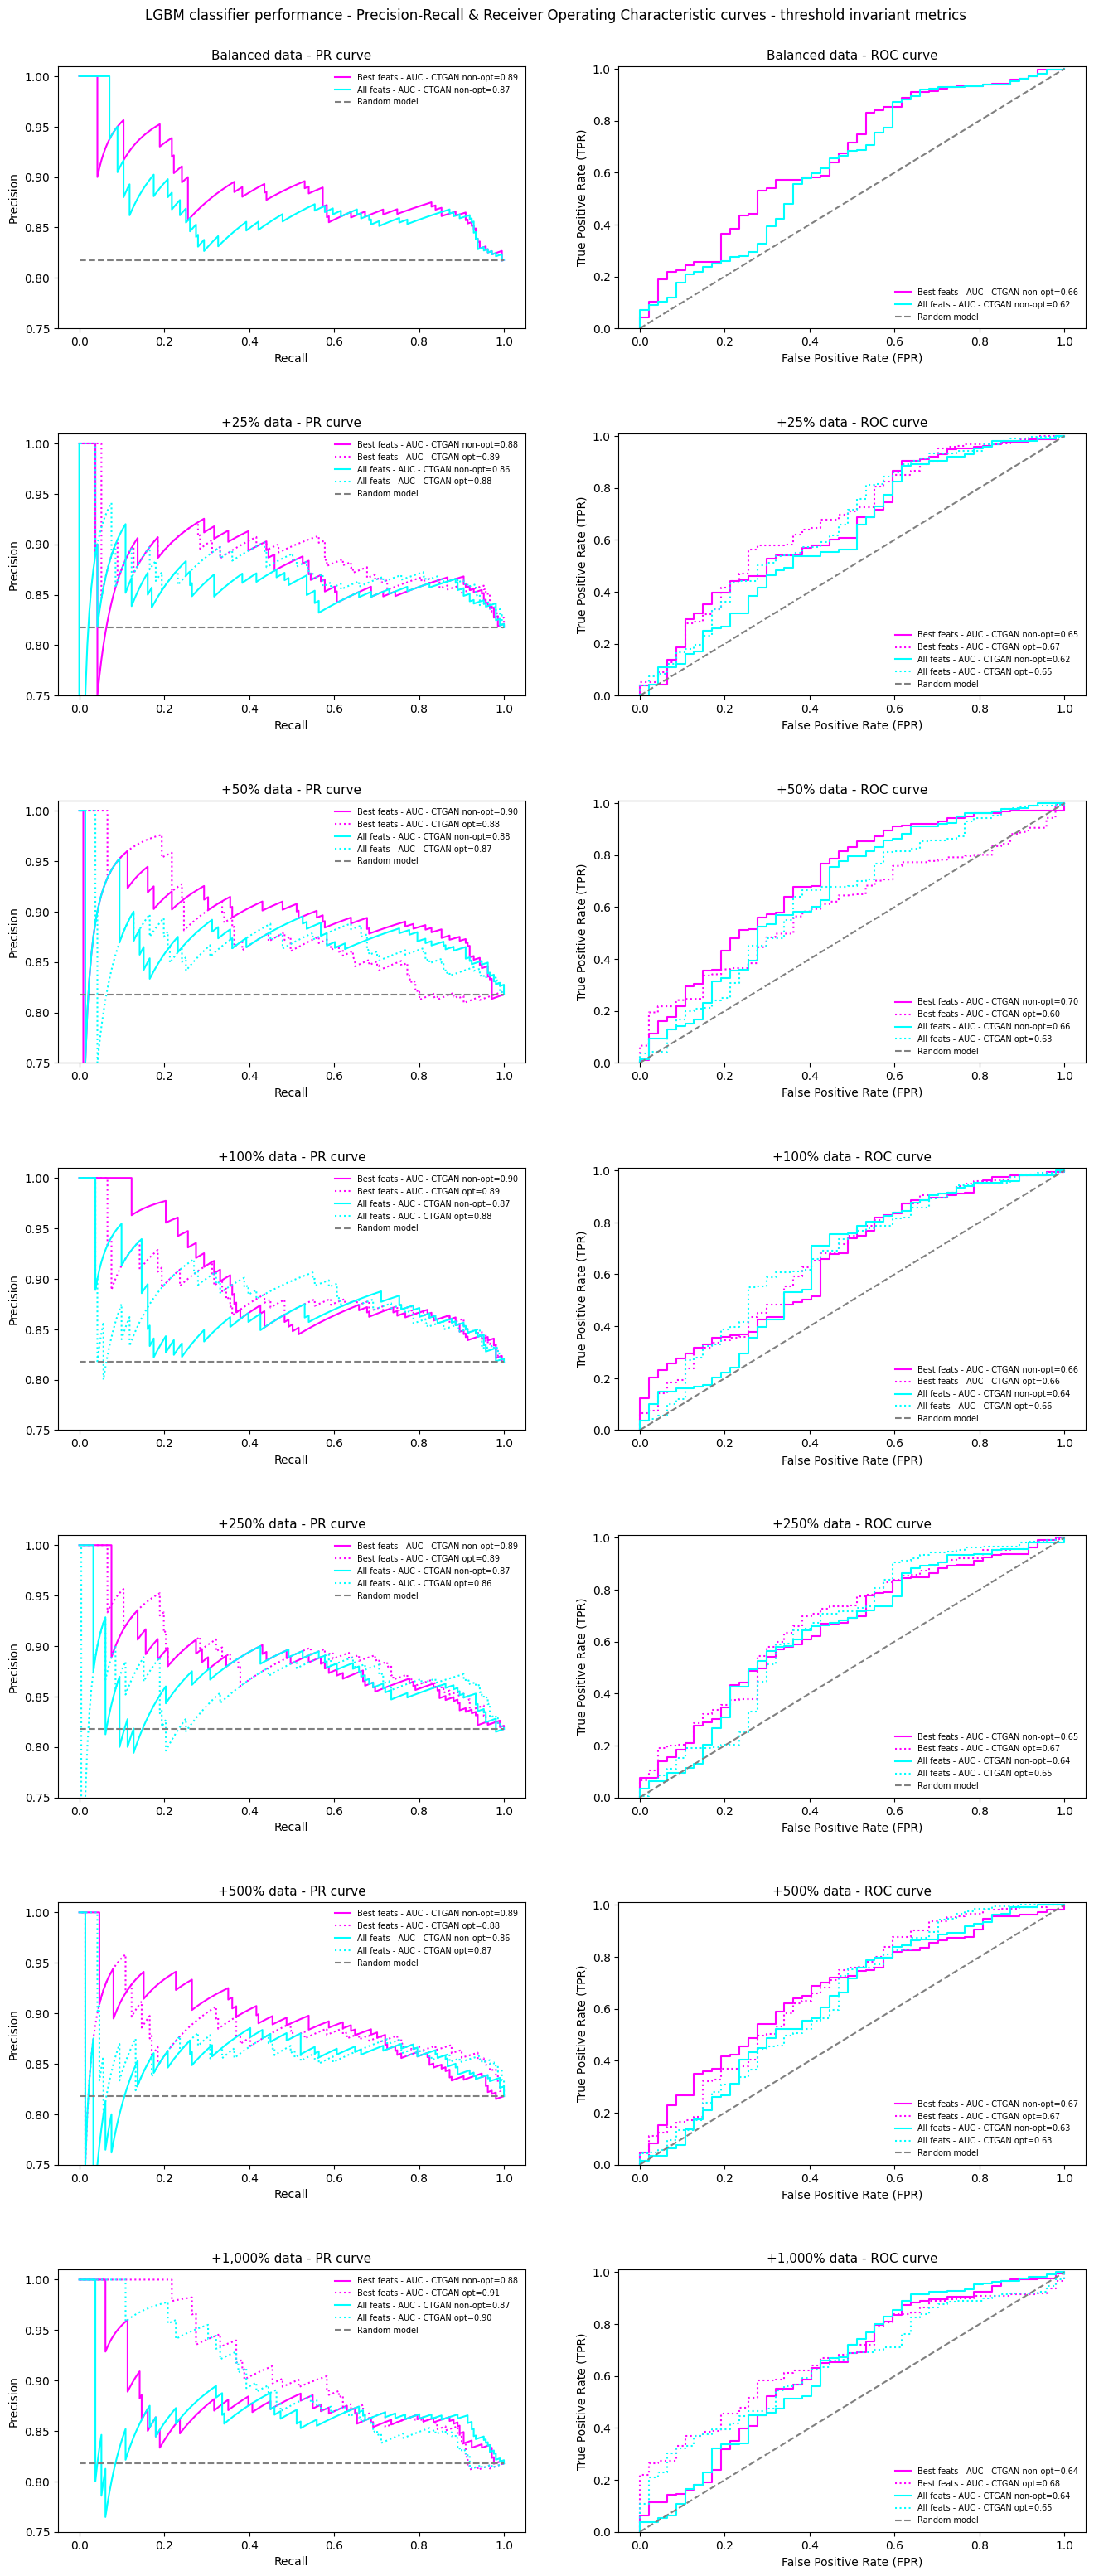

In [ ]:
fig,axes=plt.subplots(7,2,figsize=(16,35),gridspec_kw={'hspace': 0.4}) # width by height

##### Balanced - cannot use the plotting function as has less data #####

# PR curve

# Best subset of features
# Non-optimised CTGAN
pr_auc_best_feats=_bal_best_model_pr_curve_dic['_bal']['pr_auc']
axes[0,0].plot(_bal_best_model_pr_curve_dic['_bal']['recall'],_bal_best_model_pr_curve_dic['_bal']['precision'],label=f'Best feats - AUC - CTGAN non-opt={pr_auc_best_feats:.2f}',color='magenta')
# Optimised CTGAN
# No data

# All features
# Non-optimised CTGAN
pr_auc_all_feats=_bal_all_feats_pr_curve_dic['_bal']['pr_auc']
axes[0,0].plot(_bal_all_feats_pr_curve_dic['_bal']['recall'],_bal_all_feats_pr_curve_dic['_bal']['precision'],label=f'All feats - AUC - CTGAN non-opt={pr_auc_all_feats:.2f}',color='cyan')
# Optimised CTGAN
# No data

# Random model (same for all augmentation scenarios)
axes[0,0].plot([0, 1],[_bal_all_feats_pr_curve_dic['_bal']['random_model'],_bal_all_feats_pr_curve_dic['_bal']['random_model']], linestyle='--',color='gray',label='Random model')

axes[0,0].set_xlabel('Recall',fontsize=10)
axes[0,0].tick_params(axis='x',labelsize=10)
axes[0,0].set_ylabel('Precision',fontsize=10)
axes[0,0].tick_params(axis='y',labelsize=10)
axes[0,0].set_ylim(0.75,1.01)
axes[0,0].set_title('Balanced data - PR curve',fontsize=11)
axes[0,0].legend(loc='upper right',fontsize=7,frameon=False)

# ROC curve

# Best subset of features
# Non-optimised CTGAN
roc_auc_best_feats=_bal_best_model_roc_curve_dic['_bal']['roc_auc']
axes[0,1].plot(_bal_best_model_roc_curve_dic['_bal']['fpr'],_bal_best_model_roc_curve_dic['_bal']['tpr'],label=f'Best feats - AUC - CTGAN non-opt={roc_auc_best_feats:.2f}',color='magenta')
# Optimised CTGAN
# No data

# All features
# Non-optimised CTGAN
roc_auc_all_feats=_bal_all_feats_roc_curve_dic['_bal']['roc_auc']
axes[0,1].plot(_bal_all_feats_roc_curve_dic['_bal']['fpr'],_bal_all_feats_roc_curve_dic['_bal']['tpr'],label=f'All feats - AUC - CTGAN non-opt={roc_auc_all_feats:.2f}',color='cyan')
# Optimised CTGAN
# No data

# Random model (same for all augmentation scenarios)
axes[0,1].plot([0, 1], [0, 1],linestyle='--', color='gray',label='Random model')

axes[0,1].set_xlabel('False Positive Rate (FPR)',fontsize=10)
axes[0,1].tick_params(axis='x',labelsize=10)
axes[0,1].set_ylabel('True Positive Rate (TPR)',fontsize=10)
axes[0,1].tick_params(axis='y',labelsize=10)
axes[0,1].set_ylim(0.0,1.01)
axes[0,1].set_title('Balanced data - ROC curve', fontsize=11)
axes[0,1].legend(loc='lower right',fontsize=7,frameon=False)

##### +25% #####

auc_curves1(# PR curve
            _25_best_model_pr_curve_dic['_25'],   _25_o_best_model_pr_curve_dic['_25_o'],
            _25_all_feats_pr_curve_dic['_25'],    _25_o_all_feats_pr_curve_dic['_25_o'],
            # ROC curve
            _25_best_model_roc_curve_dic['_25'],  _25_o_best_model_roc_curve_dic['_25_o'],
            _25_all_feats_roc_curve_dic['_25'],   _25_o_all_feats_roc_curve_dic['_25_o'],
            # Title
            '+25% data',
            # Subplot positions - row=i, col0=j, col1=k
            1,0,1)

##### +50% #####

auc_curves1(# PR curve
            _50_best_model_pr_curve_dic['_50'],   _50_o_best_model_pr_curve_dic['_50_o'],
            _50_all_feats_pr_curve_dic['_50'],    _50_o_all_feats_pr_curve_dic['_50_o'],
            # ROC curve
            _50_best_model_roc_curve_dic['_50'],  _50_o_best_model_roc_curve_dic['_50_o'],
            _50_all_feats_roc_curve_dic['_50'],   _50_o_all_feats_roc_curve_dic['_50_o'],
            # Title
            '+50% data',
            # Subplot positions - row=i, col0=j, col1=k
            2,0,1)

##### +100% #####

auc_curves1(# PR curve
            _100_best_model_pr_curve_dic['_100'],   _100_o_best_model_pr_curve_dic['_100_o'],
            _100_all_feats_pr_curve_dic['_100'],    _100_o_all_feats_pr_curve_dic['_100_o'],
            # ROC curve
            _100_best_model_roc_curve_dic['_100'],  _100_o_best_model_roc_curve_dic['_100_o'],
            _100_all_feats_roc_curve_dic['_100'],   _100_o_all_feats_roc_curve_dic['_100_o'],
            # Title
            '+100% data',
            # Subplot positions - row=i, col0=j, col1=k
            3,0,1)

##### +250% #####

auc_curves1(# PR curve
            _250_best_model_pr_curve_dic['_250'],   _250_o_best_model_pr_curve_dic['_250_o'],
            _250_all_feats_pr_curve_dic['_250'],    _250_o_all_feats_pr_curve_dic['_250_o'],
            # ROC curve
            _250_best_model_roc_curve_dic['_250'],  _250_o_best_model_roc_curve_dic['_250_o'],
            _250_all_feats_roc_curve_dic['_250'],   _250_o_all_feats_roc_curve_dic['_250_o'],
            # Title
            '+250% data',
            # Subplot positions - row=i, col0=j, col1=k
            4,0,1)

# ##### +500% #####

auc_curves1(# PR curve
            _500_best_model_pr_curve_dic['_500'],   _500_o_best_model_pr_curve_dic['_500_o'],
            _500_all_feats_pr_curve_dic['_500'],    _500_o_all_feats_pr_curve_dic['_500_o'],
            # ROC curve
            _500_best_model_roc_curve_dic['_500'],  _500_o_best_model_roc_curve_dic['_500_o'],
            _500_all_feats_roc_curve_dic['_500'],   _500_o_all_feats_roc_curve_dic['_500_o'],
            # Title
            '+500% data',
            # Subplot positions - row=i, col0=j, col1=k
            5,0,1)

##### +1000% #####
auc_curves1(# PR curve
            _1000_best_model_pr_curve_dic['_1000'],   _1000_o_best_model_pr_curve_dic['_1000_o'],
            _1000_all_feats_pr_curve_dic['_1000'],    _1000_o_all_feats_pr_curve_dic['_1000_o'],
            # ROC curve
            _1000_best_model_roc_curve_dic['_1000'],  _1000_o_best_model_roc_curve_dic['_1000_o'],
            _1000_all_feats_roc_curve_dic['_1000'],   _1000_o_all_feats_roc_curve_dic['_1000_o'],
            # Title
            '+1,000% data',
            # Subplot positions - row=i, col0=j, col1=k
            6,0,1)

fig.suptitle('LGBM classifier performance - Precision-Recall & Receiver Operating Characteristic curves - threshold invariant metrics', fontsize=12)
fig.subplots_adjust(top=0.96)

plt.tight_layout()
plt.show()

##### 4.2.4. Compare (numeric) feature ranks across the models

In [ ]:
########### Pull together the ranks for each augmentation scenario into one dataframe ##########

##### Best feature subsets #####

# Non-optimised
best_model_feat_imp_all=_bal_best_model_feat_imp
for i in [_25_best_model_feat_imp, _50_best_model_feat_imp, _100_best_model_feat_imp, _250_best_model_feat_imp, _500_best_model_feat_imp, _1000_best_model_feat_imp]:
  best_model_feat_imp_all=pd.merge(best_model_feat_imp_all, i, on='feature', how='outer')

# Optimised
best_model_feat_imp_all_o=_25_o_best_model_feat_imp
for i in [_50_o_best_model_feat_imp, _100_o_best_model_feat_imp, _250_o_best_model_feat_imp, _500_o_best_model_feat_imp, _1000_o_best_model_feat_imp]:
  best_model_feat_imp_all_o=pd.merge(best_model_feat_imp_all_o, i, on='feature', how='outer')

##### All features #####

# Non-optimised
all_feats_feat_imp_all=_bal_all_feats_feat_imp
for i in [_25_all_feats_feat_imp, _50_all_feats_feat_imp, _100_all_feats_feat_imp, _250_all_feats_feat_imp, _500_all_feats_feat_imp, _1000_all_feats_feat_imp]:
  all_feats_feat_imp_all=pd.merge(all_feats_feat_imp_all, i, on='feature', how='outer')

# Optimised
all_feats_feat_imp_all_o=_25_o_all_feats_feat_imp
for i in [_50_o_all_feats_feat_imp, _100_o_all_feats_feat_imp, _250_o_all_feats_feat_imp, _500_o_all_feats_feat_imp, _1000_o_all_feats_feat_imp]:
  all_feats_feat_imp_all_o=pd.merge(all_feats_feat_imp_all_o, i, on='feature', how='outer')

In [ ]:
#best_model_feat_imp_all.head(4)

In [ ]:
#all_feats_feat_imp_all_o.head(4)

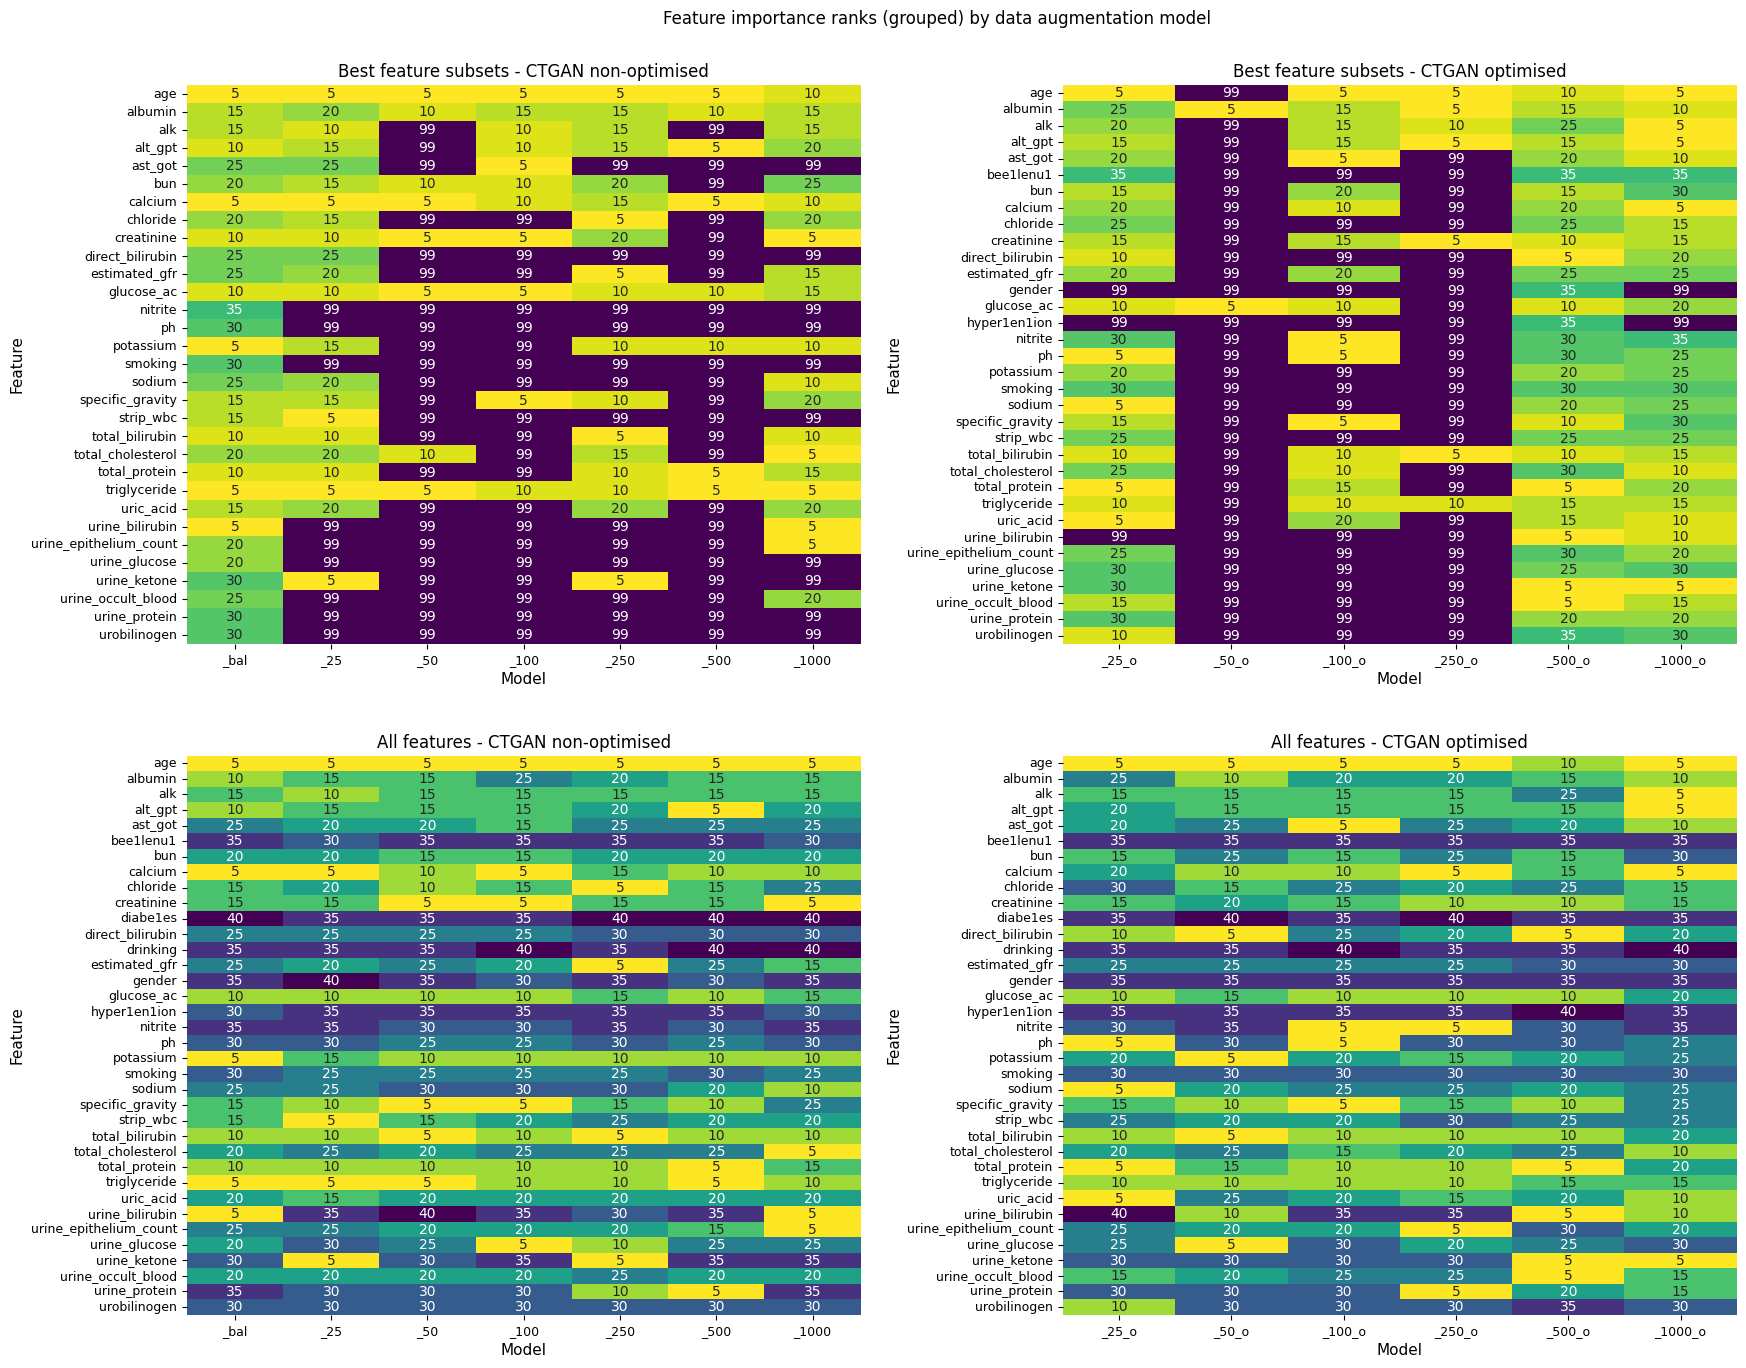

In [ ]:
########### Plot heatmaps ##########

fig,axes=plt.subplots(2,2,figsize=(20,15),gridspec_kw={'hspace': 0.2, 'wspace': 0.3}) # width by height

feat_heatmap(best_model_feat_imp_all,   'Best feature subsets - CTGAN non-optimised', 0, 0,)
feat_heatmap(best_model_feat_imp_all_o, 'Best feature subsets - CTGAN optimised',     0, 1, 1)
feat_heatmap(all_feats_feat_imp_all,    'All features - CTGAN non-optimised',         1, 0,)
feat_heatmap(all_feats_feat_imp_all_o,  'All features - CTGAN optimised',             1, 1, 1)

fig.suptitle('Feature importance ranks (grouped) by data augmentation model', fontsize=12)
fig.subplots_adjust(top=0.93)

plt.tight_layout()
plt.show()

#### 4.3. Save & load relevant objects

#### 4.5.1. Save

In [ ]:
# ######### Metric summary tables from section 4.2.2. above ##########

# # Models using all features (CTGAN non-optimised  & optimised)

# rfe_metrics_summary_all_feats1.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_all_feats1.pkl')
# rfe_metrics_summary_all_feats_o1.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_all_feats_o1.pkl')

# # Models using best subset of features (CTGAN non-optimised  & optimised)

# rfe_metrics_summary_best_model1.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_best_model1.pkl')
# rfe_metrics_summary_best_model_o1.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_best_model_o1.pkl')

# ######### Model dictionaries from section 4.1. above ##########

# # Each contains: num_feats, pr_auc, roc_auc, hypers, sel_feats, feat_names (=sel_feats), feat_imp, y_pred, y_class (based on max prob)
# # Can apply these dictionaries to model_eval() to get data ready for PR & ROC curves

# # Balanced using best subset of features (CTGAN non-optimised)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_bal_best_model', 'wb') as file:
#     pickle.dump(_bal_best_model, file)

# # Augmented datasets using best subset of features (CTGAN non-optimised)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_25_best_model', 'wb') as file:
#     pickle.dump(_25_best_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_50_best_model', 'wb') as file:
#     pickle.dump(_50_best_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_100_best_model', 'wb') as file:
#     pickle.dump(_100_best_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_250_best_model', 'wb') as file:
#     pickle.dump(_250_best_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_500_best_model', 'wb') as file:
#     pickle.dump(_500_best_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_1000_best_model', 'wb') as file:
#     pickle.dump(_1000_best_model, file)

# # Augmented datasets using best subset of features (CTGAN optimised)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_25_o_best_model', 'wb') as file:
#     pickle.dump(_25_o_best_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_50_o_best_model', 'wb') as file:
#     pickle.dump(_50_o_best_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_100_o_best_model', 'wb') as file:
#     pickle.dump(_100_o_best_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_250_o_best_model', 'wb') as file:
#     pickle.dump(_250_o_best_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_500_o_best_model', 'wb') as file:
#     pickle.dump(_500_o_best_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_1000_o_best_model', 'wb') as file:
#     pickle.dump(_1000_o_best_model, file)

# # Balanced using all features (CTGAN non-optimised) - THIS BECAME BASELINE MODEL AFTER ALL CODING FINISHED

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_bal_all_feats_model', 'wb') as file:
#     pickle.dump(_bal_all_feats_model, file)

# # Augmented datasets using all features (CTGAN non-optimised)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_25_all_feats_model', 'wb') as file:
#     pickle.dump(_25_all_feats_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_50_all_feats_model', 'wb') as file:
#     pickle.dump(_50_all_feats_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_100_all_feats_model', 'wb') as file:
#     pickle.dump(_100_all_feats_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_250_all_feats_model', 'wb') as file:
#     pickle.dump(_250_all_feats_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_500_all_feats_model', 'wb') as file:
#     pickle.dump(_500_all_feats_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_1000_all_feats_model', 'wb') as file:
#     pickle.dump(_1000_all_feats_model, file)

# # Augmented datasets using all features (CTGAN optimised)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_25_o_all_feats_model', 'wb') as file:
#     pickle.dump(_25_o_all_feats_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_50_o_all_feats_model', 'wb') as file:
#     pickle.dump(_50_o_all_feats_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_100_o_all_feats_model', 'wb') as file:
#     pickle.dump(_100_o_all_feats_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_250_o_all_feats_model', 'wb') as file:
#     pickle.dump(_250_o_all_feats_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_500_o_all_feats_model', 'wb') as file:
#     pickle.dump(_500_o_all_feats_model, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_1000_o_all_feats_model', 'wb') as file:
#     pickle.dump(_1000_o_all_feats_model, file)

##### 4.5.2.Load

In [ ]:
########## Metric summary tables ##########

# Models using all features (CTGAN non-optimised  & optimised)

rfe_metrics_summary_all_feats1=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_all_feats1.pkl')
rfe_metrics_summary_all_feats_o1=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_all_feats_o1.pkl')

# Models using best subset of features (CTGAN non-optimised  & optimised)

rfe_metrics_summary_best_model1=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_best_model1.pkl')
rfe_metrics_summary_best_model_o1=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_best_model_o1.pkl')

########## Model dictionaries ##########

# Each contains: num_feats, pr_auc, roc_auc, hypers, sel_feats, feat_names (=sel_feats), feat_imp, y_pred, y_class (based on max prob)

# Balanced using best subset of features (CTGAN non-optimised)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_bal_best_model', 'rb') as file:
    _bal_best_model=pickle.load(file)

# Augmented datasets using best subset of features (CTGAN non-optimised)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_25_best_model', 'rb') as file:
    _25_best_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_50_best_model', 'rb') as file:
    _50_best_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_100_best_model', 'rb') as file:
    _100_best_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_250_best_model', 'rb') as file:
    _250_best_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_500_best_model', 'rb') as file:
    _500_best_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_1000_best_model', 'rb') as file:
    _1000_best_model=pickle.load(file)

# Augmented datasets using best subset of features (CTGAN optimised)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_25_o_best_model', 'rb') as file:
    _25_o_best_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_50_o_best_model', 'rb') as file:
    _50_o_best_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_100_o_best_model', 'rb') as file:
    _100_o_best_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_250_o_best_model', 'rb') as file:
    _250_o_best_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_500_o_best_model', 'rb') as file:
    _500_o_best_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_1000_o_best_model', 'rb') as file:
    _1000_o_best_model=pickle.load(file)

# Balanced using all features (CTGAN non-optimised) - THIS BECAME BASELINE MODEL AFTER ALL CODING FINISHED

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_bal_all_feats_model', 'rb') as file:
    _bal_all_feats_model=pickle.load(file)

# Augmented datasets using all features (CTGAN non-optimised)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_25_all_feats_model', 'rb') as file:
    _25_all_feats_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_50_all_feats_model', 'rb') as file:
    _50_all_feats_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_100_all_feats_model', 'rb') as file:
    _100_all_feats_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_250_all_feats_model', 'rb') as file:
    _250_all_feats_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_500_all_feats_model', 'rb') as file:
    _500_all_feats_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_1000_all_feats_model', 'rb') as file:
    _1000_all_feats_model=pickle.load(file)

# Augmented datasets using all features (CTGAN optimised)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_25_o_all_feats_model', 'rb') as file:
    _25_o_all_feats_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_50_o_all_feats_model', 'rb') as file:
    _50_o_all_feats_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_100_o_all_feats_model', 'rb') as file:
    _100_o_all_feats_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_250_o_all_feats_model', 'rb') as file:
    _250_o_all_feats_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_500_o_all_feats_model', 'rb') as file:
    _500_o_all_feats_model=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_1000_o_all_feats_model', 'rb') as file:
    _1000_o_all_feats_model=pickle.load(file)

### 5. Create LGBM classification models using best performing feature subsets & tuned hyperparameters (random search)

- As the use of selected subset of features improved model performance the objective here is to tune the hyperparameters of those models for improved performance
- Here will consider a randomized search on a considered parameter grid with many iterations
- Again using PR-AUC for evaluating best hyperparameters
- Initial grid was very broad in value ranges and performed poorly so a narrower grid based around default values is used. This will be used for all the different augmented datasets and for both search algorithms (random and GA) to enable a comparison between the two search algorithms. Did not have time to consider a two step approach of manually customising a grid per each augmentation dataset after repeated runs
- Each run will consider 10,000 random selections of hyperparameter combinations to be evaluated on each validation fold - so a total of 50,000 evaluated folds in total per model
- For each augmented dataset will consider the best subset of features found using RFE above

#### 5.1. Get best subset of features per model (from RFE above)

In [ ]:
# Balanced using best subset of features (CTGAN non-optimised)
_bal_rfe_sel_feats=_bal_best_model['sel_feats'].tolist()

# Augmented datasets using best subset of features (CTGAN non-optimised)
_25_rfe_sel_feats=_25_best_model['sel_feats'].tolist()
_50_rfe_sel_feats=_50_best_model['sel_feats'].tolist()
_100_rfe_sel_feats=_100_best_model['sel_feats'].tolist()
_250_rfe_sel_feats=_250_best_model['sel_feats'].tolist()
_500_rfe_sel_feats=_500_best_model['sel_feats'].tolist()
_1000_rfe_sel_feats=_1000_best_model['sel_feats'].tolist()

# Augmented datasets using best subset of features (CTGAN optimised)
_25_o_rfe_sel_feats=_25_o_best_model['sel_feats'].tolist()
_50_o_rfe_sel_feats=_50_o_best_model['sel_feats'].tolist()
_100_o_rfe_sel_feats=_100_o_best_model['sel_feats'].tolist()
_250_o_rfe_sel_feats=_250_o_best_model['sel_feats'].tolist()
_500_o_rfe_sel_feats=_500_o_best_model['sel_feats'].tolist()
_1000_o_rfe_sel_feats=_1000_o_best_model['sel_feats'].tolist()

#### 5.2. Create models using selected features & optimized hyperparameters

Build the models

In [ ]:
# Define the function to evaluate the validation fold for hyperparameter selection
pr_auc=make_scorer(pr_auc_eval,greater_is_better=True,needs_proba=True)

# Baseline dataset (='balanced') using non-optimised CTGAN
y_pred_bal,     y_class_bal,    feat_names_bal,     feat_imp_bal,     best_model_bal,     hypers_bal,     valid_score_bal     = lgbm_model(pr_auc,  _bal_rfe_sel_feats,     10000, x_train_bal,    y_train_bal,    x_test_bal,     y_test_bal)

# Augmented datasets using non-optimised CTGAN
y_pred_25,      y_class_25,     feat_names_25,      feat_imp_25,      best_model_25,      hypers_25,      valid_score_25      = lgbm_model(pr_auc,  _25_rfe_sel_feats,      10000, x_train_25,     y_train_25,     x_test_25,      y_test_25)
y_pred_50,      y_class_50,     feat_names_50,      feat_imp_50,      best_model_50,      hypers_50,      valid_score_50      = lgbm_model(pr_auc,  _50_rfe_sel_feats,      10000, x_train_50,     y_train_50,     x_test_50,      y_test_50)
y_pred_100,     y_class_100,    feat_names_100,     feat_imp_100,     best_model_100,     hypers_100,     valid_score_100     = lgbm_model(pr_auc,  _100_rfe_sel_feats,     10000, x_train_100,    y_train_100,    x_test_100,     y_test_100)
y_pred_250,     y_class_250,    feat_names_250,     feat_imp_250,     best_model_250,     hypers_250,     valid_score_250     = lgbm_model(pr_auc,  _250_rfe_sel_feats,     10000, x_train_250,    y_train_250,    x_test_250,     y_test_250)
y_pred_500,     y_class_500,    feat_names_500,     feat_imp_500,     best_model_500,     hypers_500,     valid_score_500     = lgbm_model(pr_auc,  _500_rfe_sel_feats,     10000, x_train_500,    y_train_500,    x_test_500,     y_test_500)
y_pred_1000,    y_class_1000,   feat_names_1000,    feat_imp_1000,    best_model_1000,    hypers_1000,    valid_score_1000    = lgbm_model(pr_auc,  _1000_rfe_sel_feats,    10000, x_train_1000,   y_train_1000,   x_test_1000,    y_test_1000)

# Augmented datasets using optimised CTGAN
y_pred_25_o,    y_class_25_o,   feat_names_25_o,    feat_imp_25_o,    best_model_25_o,    hypers_25_o,    valid_score_25_o    = lgbm_model(pr_auc,  _25_o_rfe_sel_feats,    10000, x_train_25_o,   y_train_25_o,   x_test_25_o,    y_test_25_o)
y_pred_50_o,    y_class_50_o,   feat_names_50_o,    feat_imp_50_o,    best_model_50_o,    hypers_50_o,    valid_score_50_o    = lgbm_model(pr_auc,  _50_o_rfe_sel_feats,    10000, x_train_50_o,   y_train_50_o,   x_test_50_o,    y_test_50_o)
y_pred_100_o,   y_class_100_o,  feat_names_100_o,   feat_imp_100_o,   best_model_100_o,   hypers_100_o,   valid_score_100_o   = lgbm_model(pr_auc,  _100_o_rfe_sel_feats,   10000, x_train_100_o,  y_train_100_o,  x_test_100_o,   y_test_100_o)
y_pred_250_o,   y_class_250_o,  feat_names_250_o,   feat_imp_250_o,   best_model_250_o,   hypers_250_o,   valid_score_250_o   = lgbm_model(pr_auc,  _250_o_rfe_sel_feats,   10000, x_train_250_o,  y_train_250_o,  x_test_250_o,   y_test_250_o)
y_pred_500_o,   y_class_500_o,  feat_names_500_o,   feat_imp_500_o,   best_model_500_o,   hypers_500_o,   valid_score_500_o   = lgbm_model(pr_auc,  _500_o_rfe_sel_feats,   10000, x_train_500_o,  y_train_500_o,  x_test_500_o,   y_test_500_o)
y_pred_1000_o,  y_class_1000_o, feat_names_1000_o,  feat_imp_1000_o,  best_model_1000_o,  hypers_1000_o,  valid_score_1000_o  = lgbm_model(pr_auc,  _1000_o_rfe_sel_feats,  10000, x_train_1000_o, y_train_1000_o, x_test_1000_o,  y_test_1000_o)

#### 5.3. Evaluate models for each augmentation scenario

##### 5.3.1. Get performance data

In [ ]:
# '_rs' = random search

# Balanced (non-optimised)

_bal_best_model_metrics_rs,      _bal_best_model_feat_imp_rs,     _bal_best_model_pr_curve_dic_rs,     _bal_best_model_roc_curve_dic_rs     = model_eval('_bal',    y_test_bal,    y_pred_bal,     y_class_bal,    feat_names_bal,    feat_imp_bal,    valid_score=valid_score_bal,  assign_method='ss')

# Non-optimized CTGAN

_25_best_model_metrics_rs,       _25_best_model_feat_imp_rs,      _25_best_model_pr_curve_dic_rs,      _25_best_model_roc_curve_dic_rs      = model_eval('_25',     y_test_25,     y_pred_25,      y_class_25,     feat_names_25,     feat_imp_25,     valid_score=valid_score_25,   assign_method='ss')
_50_best_model_metrics_rs,       _50_best_model_feat_imp_rs,      _50_best_model_pr_curve_dic_rs,      _50_best_model_roc_curve_dic_rs      = model_eval('_50',     y_test_50,     y_pred_50,      y_class_50,     feat_names_50,     feat_imp_50,     valid_score=valid_score_50,   assign_method='ss')
_100_best_model_metrics_rs,      _100_best_model_feat_imp_rs,     _100_best_model_pr_curve_dic_rs,     _100_best_model_roc_curve_dic_rs     = model_eval('_100',    y_test_100,    y_pred_100,     y_class_100,    feat_names_100,    feat_imp_100,    valid_score=valid_score_100,  assign_method='ss')
_250_best_model_metrics_rs,      _250_best_model_feat_imp_rs,     _250_best_model_pr_curve_dic_rs,     _250_best_model_roc_curve_dic_rs     = model_eval('_250',    y_test_250,    y_pred_250,     y_class_250,    feat_names_250,    feat_imp_250,    valid_score=valid_score_250,  assign_method='ss')
_500_best_model_metrics_rs,      _500_best_model_feat_imp_rs,     _500_best_model_pr_curve_dic_rs,     _500_best_model_roc_curve_dic_rs     = model_eval('_500',    y_test_500,    y_pred_500,     y_class_500,    feat_names_500,    feat_imp_500,    valid_score=valid_score_500,  assign_method='ss')
_1000_best_model_metrics_rs,     _1000_best_model_feat_imp_rs,    _1000_best_model_pr_curve_dic_rs,    _1000_best_model_roc_curve_dic_rs    = model_eval('_1000',   y_test_1000,   y_pred_1000,    y_class_1000,   feat_names_1000,   feat_imp_1000,   valid_score=valid_score_1000, assign_method='ss')

# Optimised CTGAN

_25_o_best_model_metrics_rs,     _25_o_best_model_feat_imp_rs,    _25_o_best_model_pr_curve_dic_rs,    _25_o_best_model_roc_curve_dic_rs    = model_eval('_25_o',   y_test_25_o,   y_pred_25_o,    y_class_25_o,   feat_names_25_o,   feat_imp_25_o,   valid_score=valid_score_25_o,   assign_method='ss')
_50_o_best_model_metrics_rs,     _50_o_best_model_feat_imp_rs,    _50_o_best_model_pr_curve_dic_rs,    _50_o_best_model_roc_curve_dic_rs    = model_eval('_50_o',   y_test_50_o,   y_pred_50_o,    y_class_50_o,   feat_names_50_o,   feat_imp_50_o,   valid_score=valid_score_50_o,   assign_method='ss')
_100_o_best_model_metrics_rs,    _100_o_best_model_feat_imp_rs,   _100_o_best_model_pr_curve_dic_rs,   _100_o_best_model_roc_curve_dic_rs   = model_eval('_100_o',  y_test_100_o,  y_pred_100_o,   y_class_100_o,  feat_names_100_o,  feat_imp_100_o,  valid_score=valid_score_100_o,  assign_method='ss')
_250_o_best_model_metrics_rs,    _250_o_best_model_feat_imp_rs,   _250_o_best_model_pr_curve_dic_rs,   _250_o_best_model_roc_curve_dic_rs   = model_eval('_250_o',  y_test_250_o,  y_pred_250_o,   y_class_250_o,  feat_names_250_o,  feat_imp_250_o,  valid_score=valid_score_250_o,  assign_method='ss')
_500_o_best_model_metrics_rs,    _500_o_best_model_feat_imp_rs,   _500_o_best_model_pr_curve_dic_rs,   _500_o_best_model_roc_curve_dic_rs   = model_eval('_500_o',  y_test_500_o,  y_pred_500_o,   y_class_500_o,  feat_names_500_o,  feat_imp_500_o,  valid_score=valid_score_500_o,  assign_method='ss')
_1000_o_best_model_metrics_rs,   _1000_o_best_model_feat_imp_rs,  _1000_o_best_model_pr_curve_dic_rs,  _1000_o_best_model_roc_curve_dic_rs  = model_eval('_1000_o', y_test_1000_o, y_pred_1000_o,  y_class_1000_o, feat_names_1000_o, feat_imp_1000_o, valid_score=valid_score_1000_o, assign_method='ss')

##### 5.3.2. Create summary tables of performance metrics
- 'bal' is the reference model and comprises data samples from non-optimised CTGAN
- 'bal' does consider a best subset of features
- Did not join the number of features in each model to these summary tables as they are the same as for RFE models above

In [ ]:
# Augmented datasets using non-optimised CTGAN
rfe_metrics_summary_best_model_rs    = pd.concat([_bal_best_model_metrics_rs, _25_best_model_metrics_rs,     _50_best_model_metrics_rs,     _100_best_model_metrics_rs,    _250_best_model_metrics_rs,    _500_best_model_metrics_rs,    _1000_best_model_metrics_rs],    axis=0).drop(columns=['valid_score'],axis=1)

# Augmented datasets using optimised CTGAN
rfe_metrics_summary_best_model_o_rs  = pd.concat([_bal_best_model_metrics_rs, _25_o_best_model_metrics_rs,   _50_o_best_model_metrics_rs,   _100_o_best_model_metrics_rs,  _250_o_best_model_metrics_rs,  _500_o_best_model_metrics_rs,  _1000_o_best_model_metrics_rs],  axis=0).drop(columns=['valid_score'],axis=1)

In [ ]:
# Augmented datasets - non-optimised CTGAN - best feature subset - random search hypers
rfe_metrics_summary_best_model_rs

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc
_bal,130,31,16,81,0.467648,0.624031,0.616114,0.890411,0.659574,0.728291,0.874082,0.660785
_25,155,22,25,56,0.459705,0.686047,0.734597,0.861111,0.468085,0.792839,0.849353,0.598064
_50,124,27,20,87,0.477884,0.585271,0.587678,0.861111,0.574468,0.698592,0.847565,0.581980
_100,170,21,26,41,0.485676,0.740310,0.805687,0.867347,0.446809,0.835381,0.851005,0.606938
_250,146,27,20,65,0.480271,0.670543,0.691943,0.879518,0.574468,0.774536,0.863173,0.636987
_500,130,31,16,81,0.504873,0.624031,0.616114,0.890411,0.659574,0.728291,0.880887,0.639508
_1000,165,23,24,46,0.512602,0.728682,0.781991,0.873016,0.489362,0.825000,0.882951,0.638600


In [ ]:
# Augmented datasets - optimised CTGAN - best feature subset - random search hypers
rfe_metrics_summary_best_model_o_rs

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc
_bal,130,31,16,81,0.467648,0.624031,0.616114,0.890411,0.659574,0.728291,0.874082,0.660785
_25_o,158,23,24,53,0.459366,0.701550,0.748815,0.868132,0.489362,0.804071,0.881833,0.653171
_50_o,102,38,9,109,0.728103,0.542636,0.483412,0.918919,0.808511,0.633540,0.883573,0.593627
_100_o,197,5,42,14,0.484444,0.782946,0.933649,0.824268,0.106383,0.875556,0.823797,0.519764
_250_o,146,28,19,65,0.461451,0.674419,0.691943,0.884848,0.595745,0.776596,0.900375,0.684885
_500_o,170,20,27,41,0.473543,0.736434,0.805687,0.862944,0.425532,0.833333,0.868262,0.612030
_1000_o,111,36,11,100,0.662760,0.569767,0.526066,0.909836,0.765957,0.666667,0.901734,0.656953


##### 5.3.3. Plot PR & ROC curves

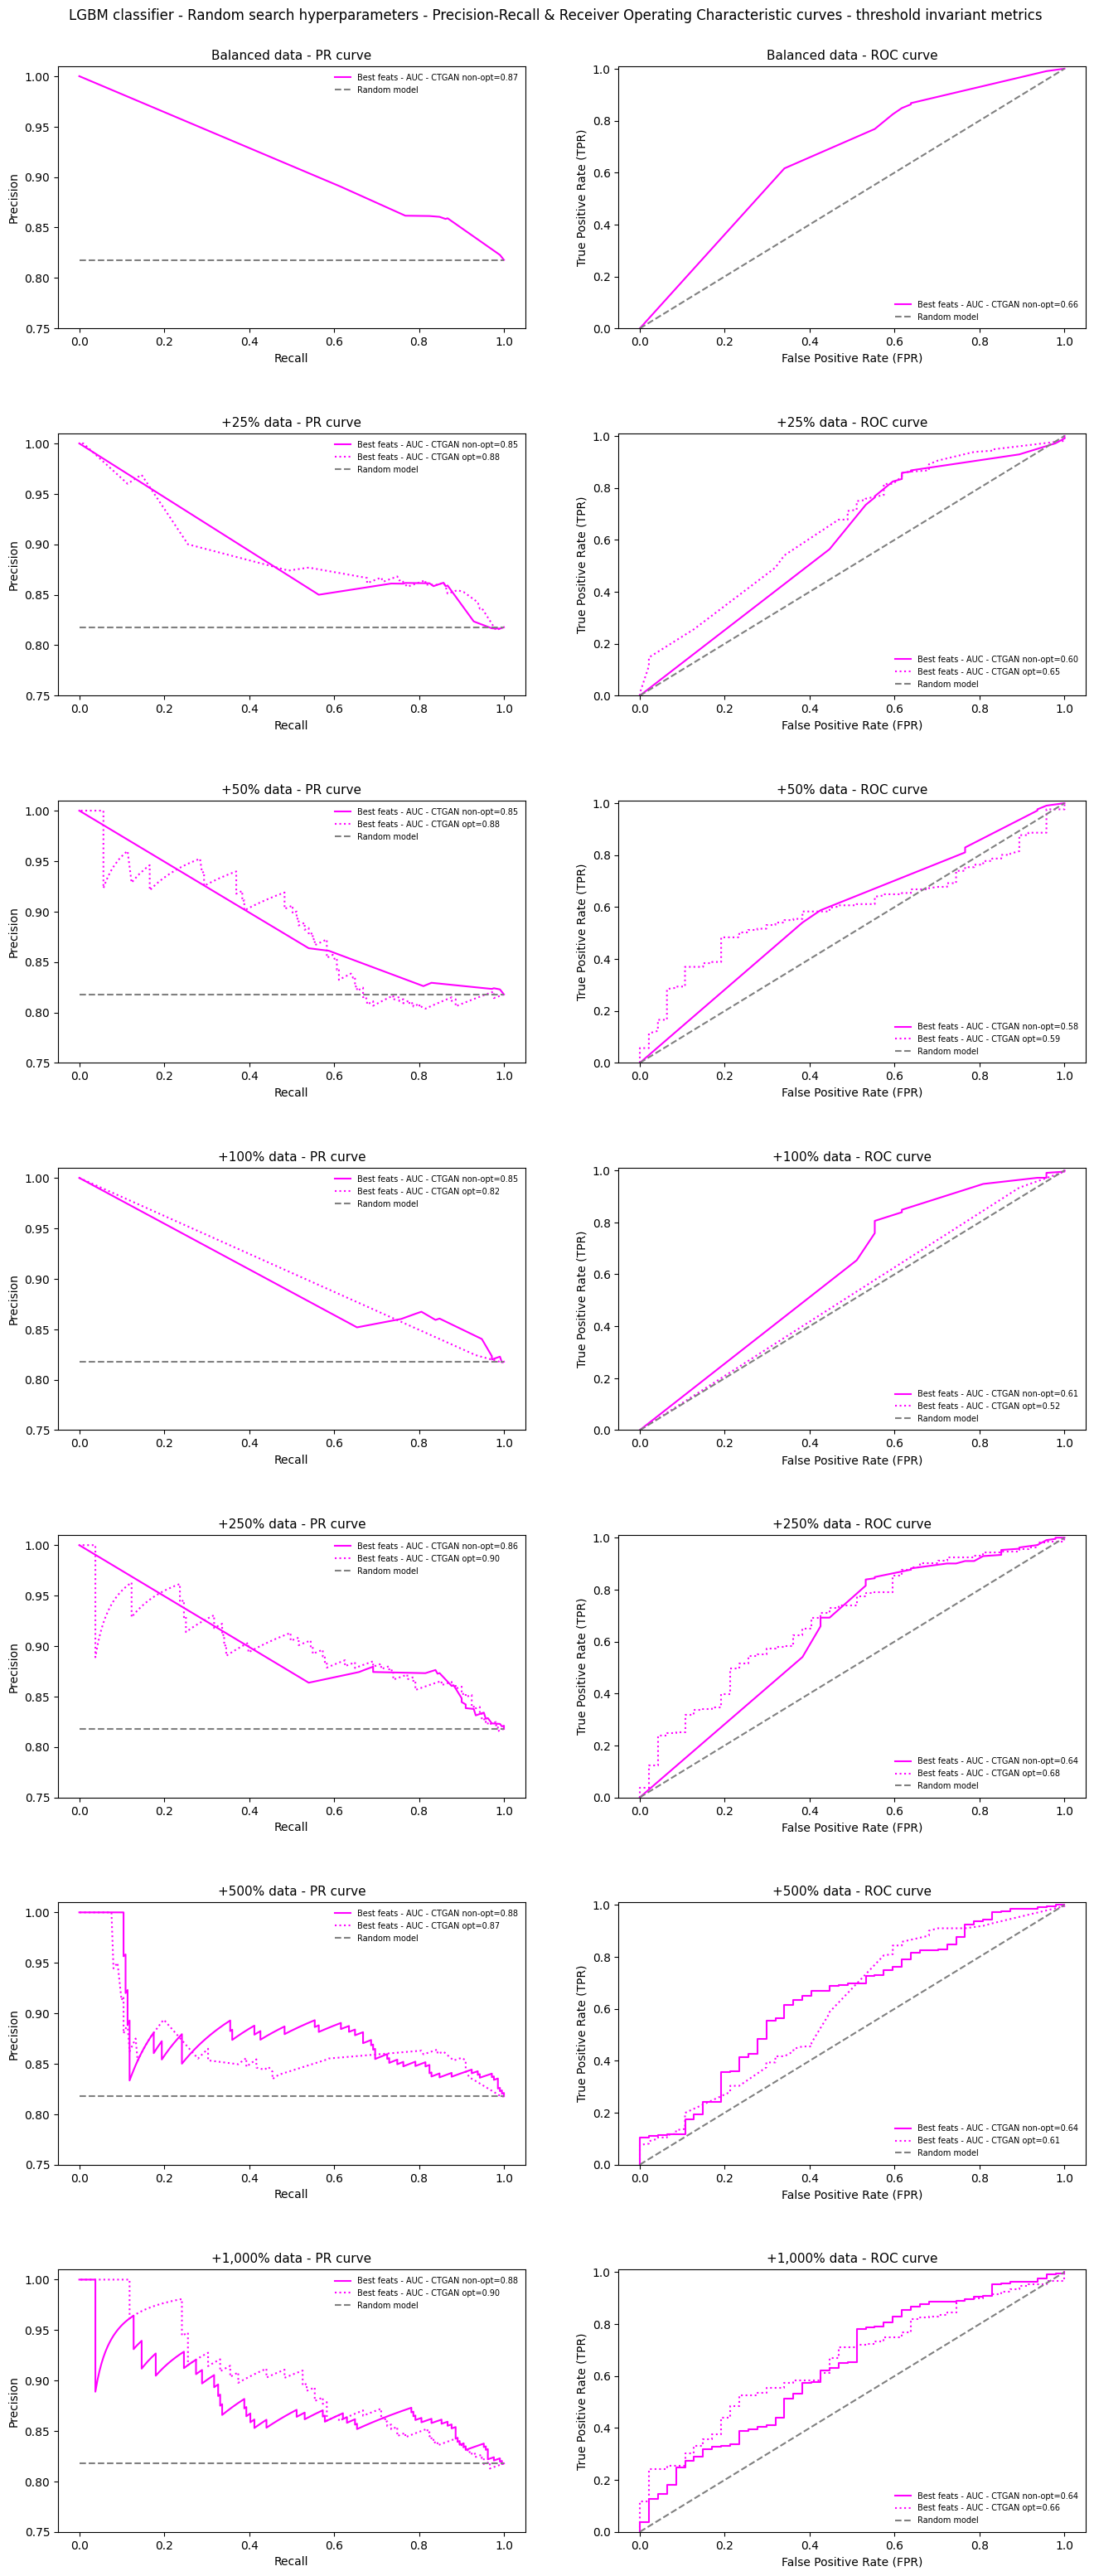

In [ ]:
fig,axes=plt.subplots(7,2,figsize=(16,35),gridspec_kw={'hspace': 0.4}) # width by height

##### Balanced - cannot use the plotting function as has less data #####

# PR curve

# Best subset of features
# Non-optimised CTGAN
pr_auc_best_feats_rs=_bal_best_model_pr_curve_dic_rs['_bal']['pr_auc']
axes[0,0].plot(_bal_best_model_pr_curve_dic_rs['_bal']['recall'],_bal_best_model_pr_curve_dic_rs['_bal']['precision'],label=f'Best feats - AUC - CTGAN non-opt={pr_auc_best_feats_rs:.2f}',color='magenta')
# Optimised CTGAN
# No data

# Random model (same for all augmentation scenarios)
axes[0,0].plot([0, 1],[_bal_best_model_pr_curve_dic_rs['_bal']['random_model'],_bal_best_model_pr_curve_dic_rs['_bal']['random_model']], linestyle='--',color='gray',label='Random model')

axes[0,0].set_xlabel('Recall',fontsize=10)
axes[0,0].tick_params(axis='x',labelsize=10)
axes[0,0].set_ylabel('Precision',fontsize=10)
axes[0,0].tick_params(axis='y',labelsize=10)
axes[0,0].set_ylim(0.75,1.01)
axes[0,0].set_title('Balanced data - PR curve',fontsize=11)
axes[0,0].legend(loc='upper right',fontsize=7,frameon=False)

# ROC curve

# Best subset of features
# Non-optimised CTGAN
roc_auc_best_feats_rs=_bal_best_model_roc_curve_dic_rs['_bal']['roc_auc']
axes[0,1].plot(_bal_best_model_roc_curve_dic_rs['_bal']['fpr'],_bal_best_model_roc_curve_dic_rs['_bal']['tpr'],label=f'Best feats - AUC - CTGAN non-opt={roc_auc_best_feats_rs:.2f}',color='magenta')
# Optimised CTGAN
# No data

# Random model (same for all augmentation scenarios)
axes[0,1].plot([0, 1], [0, 1],linestyle='--', color='gray',label='Random model')

axes[0,1].set_xlabel('False Positive Rate (FPR)',fontsize=10)
axes[0,1].tick_params(axis='x',labelsize=10)
axes[0,1].set_ylabel('True Positive Rate (TPR)',fontsize=10)
axes[0,1].tick_params(axis='y',labelsize=10)
axes[0,1].set_ylim(0.0,1.01)
axes[0,1].set_title('Balanced data - ROC curve', fontsize=11)
axes[0,1].legend(loc='lower right',fontsize=7,frameon=False)

##### +25% #####

auc_curves2(# PR curve
            _25_best_model_pr_curve_dic_rs['_25'],   _25_o_best_model_pr_curve_dic_rs['_25_o'],
            # ROC curve
            _25_best_model_roc_curve_dic_rs['_25'],  _25_o_best_model_roc_curve_dic_rs['_25_o'],
            # Title
            '+25% data',
            # Subplot positions - row=i, col0=j, col1=k
            1,0,1)

##### +50% #####

auc_curves2(# PR curve
            _50_best_model_pr_curve_dic_rs['_50'],   _50_o_best_model_pr_curve_dic_rs['_50_o'],
            # ROC curve
            _50_best_model_roc_curve_dic_rs['_50'],  _50_o_best_model_roc_curve_dic_rs['_50_o'],
            # Title
            '+50% data',
            # Subplot positions - row=i, col0=j, col1=k
            2,0,1)

##### +100% #####

auc_curves2(# PR curve
            _100_best_model_pr_curve_dic_rs['_100'],   _100_o_best_model_pr_curve_dic_rs['_100_o'],
            # ROC curve
            _100_best_model_roc_curve_dic_rs['_100'],  _100_o_best_model_roc_curve_dic_rs['_100_o'],
            # Title
            '+100% data',
            # Subplot positions - row=i, col0=j, col1=k
            3,0,1)

##### +250% #####

auc_curves2(# PR curve
            _250_best_model_pr_curve_dic_rs['_250'],   _250_o_best_model_pr_curve_dic_rs['_250_o'],
            # ROC curve
            _250_best_model_roc_curve_dic_rs['_250'],  _250_o_best_model_roc_curve_dic_rs['_250_o'],
            # Title
            '+250% data',
            # Subplot positions - row=i, col0=j, col1=k
            4,0,1)

# ##### +500% #####

auc_curves2(# PR curve
            _500_best_model_pr_curve_dic_rs['_500'],   _500_o_best_model_pr_curve_dic_rs['_500_o'],
            # ROC curve
            _500_best_model_roc_curve_dic_rs['_500'],  _500_o_best_model_roc_curve_dic_rs['_500_o'],
            # Title
            '+500% data',
            # Subplot positions - row=i, col0=j, col1=k
            5,0,1)

##### +1000% #####
auc_curves2(# PR curve
            _1000_best_model_pr_curve_dic_rs['_1000'],   _1000_o_best_model_pr_curve_dic_rs['_1000_o'],
            # ROC curve
            _1000_best_model_roc_curve_dic_rs['_1000'],  _1000_o_best_model_roc_curve_dic_rs['_1000_o'],
            # Title
            '+1,000% data',
            # Subplot positions - row=i, col0=j, col1=k
            6,0,1)

fig.suptitle('LGBM classifier - Random search hyperparameters - Precision-Recall & Receiver Operating Characteristic curves - threshold invariant metrics', fontsize=12)
fig.subplots_adjust(top=0.96)

plt.tight_layout()
plt.show()

##### 5.3.4. Review feature ranks per model

Pull together the ranks for each augmentation scenario into one dataframe

In [ ]:
# Non-optimised
best_model_feat_imp_all_rs=_bal_best_model_feat_imp_rs
for i in [_25_best_model_feat_imp_rs, _50_best_model_feat_imp_rs, _100_best_model_feat_imp_rs, _250_best_model_feat_imp_rs, _500_best_model_feat_imp_rs, _1000_best_model_feat_imp_rs]:
  best_model_feat_imp_all_rs=pd.merge(best_model_feat_imp_all_rs, i, on='feature', how='outer')

# Optimised
best_model_feat_imp_all_o_rs=_25_o_best_model_feat_imp_rs
for i in [_50_o_best_model_feat_imp_rs, _100_o_best_model_feat_imp_rs, _250_o_best_model_feat_imp_rs, _500_o_best_model_feat_imp_rs, _1000_o_best_model_feat_imp_rs]:
  best_model_feat_imp_all_o_rs=pd.merge(best_model_feat_imp_all_o_rs, i, on='feature', how='outer')

In [ ]:
#best_model_feat_imp_all_rs.head()

In [ ]:
#best_model_feat_imp_all_o_rs.head()

##### 5.3.5. Plot heatmaps

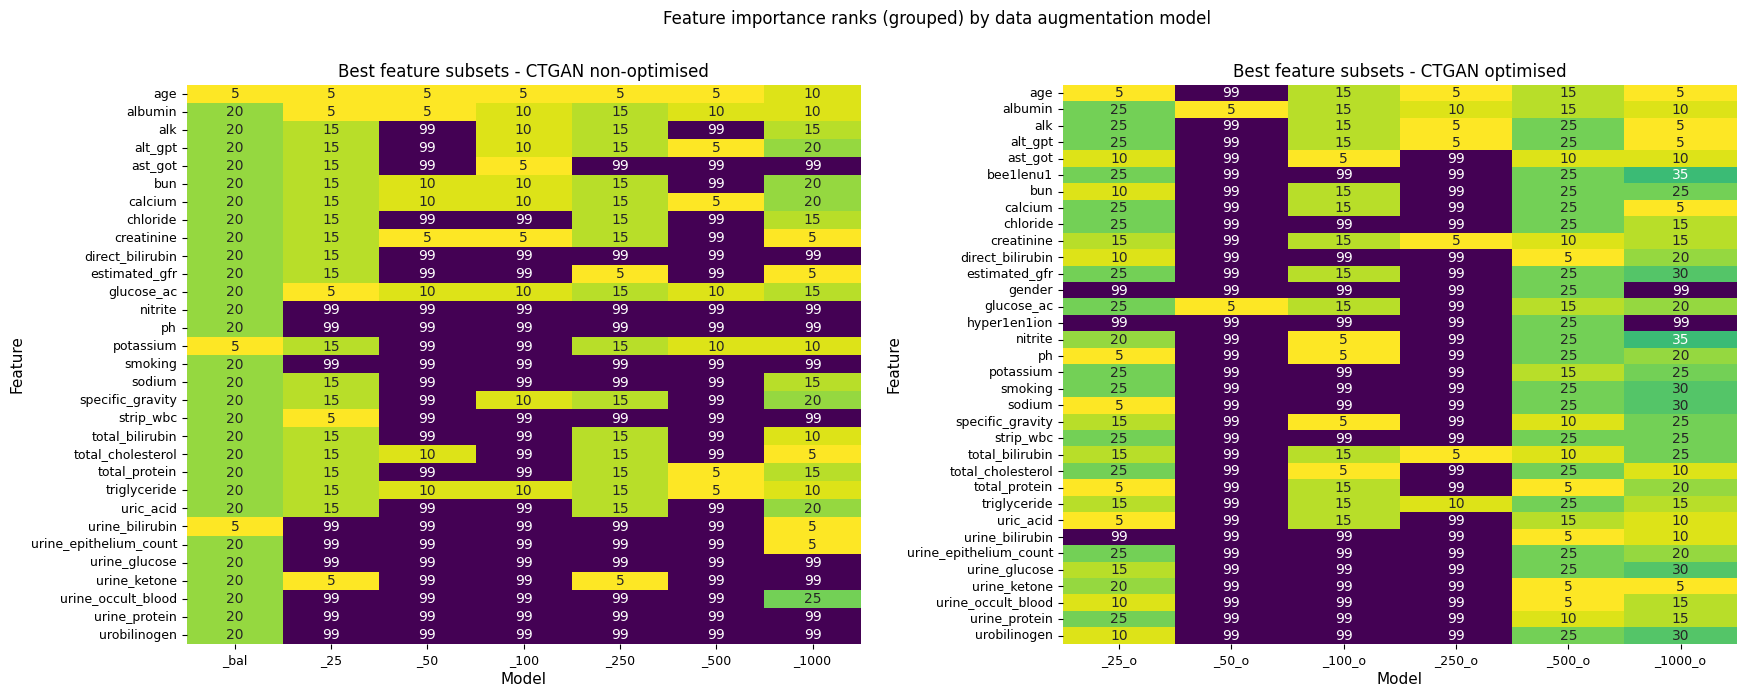

In [ ]:
fig,axes=plt.subplots(2,2, figsize=(20,15),gridspec_kw={'hspace': 0.2, 'wspace': 0.3}) # width by height

feat_heatmap(best_model_feat_imp_all_rs,   'Best feature subsets - CTGAN non-optimised', 0,0,)
feat_heatmap(best_model_feat_imp_all_o_rs, 'Best feature subsets - CTGAN optimised',     0,1,1)

fig.delaxes(axes[1][0])
fig.delaxes(axes[1][1])

fig.suptitle('Feature importance ranks (grouped) by data augmentation model', fontsize=12)
fig.subplots_adjust(top=0.93)

plt.tight_layout()
plt.show()

#### 5.4. Save & load relevant objects

##### 5.4.1. Save

In [ ]:
# ###### Metric summary tables from section 5.3.2. above #####

# # Best subset of features - random searched hyperparameters - CTGAN non-optimised
# rfe_metrics_summary_best_model_rs.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_best_model_rs.pkl')

# # Best subset of features - random searched hyperparameters - CTGAN optimised
# rfe_metrics_summary_best_model_o_rs.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_best_model_o_rs.pkl')

# ##### Model object & dictionaries from section 5.2. above ##########

# # Can apply the dictionaries to model_eval() to get data ready for PR & ROC curves

# # Balanced - best subset of features  - random searched hyperparameters - CTGAN non-optimised

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_bal_rs', 'wb') as file:
#   pickle.dump(y_pred_bal, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_bal_rs', 'wb') as file:
#   pickle.dump(y_class_bal, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_bal_rs', 'wb') as file:
#   pickle.dump(feat_names_bal, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_bal_rs', 'wb') as file:
#   pickle.dump(feat_imp_bal, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_bal_rs', 'wb') as file:
#   pickle.dump(best_model_bal, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_bal_rs', 'wb') as file:
#   pickle.dump(hypers_bal, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_bal_rs', 'wb') as file:
#   pickle.dump(valid_score_bal, file)

# # Augmented datasets - best subset of features - random searched hyperparameters - CTGAN non-optimised

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_25_rs', 'wb') as file:
#   pickle.dump(y_pred_25, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_25_rs', 'wb') as file:
#   pickle.dump(y_class_25, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_25_rs', 'wb') as file:
#   pickle.dump(feat_names_25, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_25_rs', 'wb') as file:
#   pickle.dump(feat_imp_25, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_25_rs', 'wb') as file:
#   pickle.dump(best_model_25, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_25_rs', 'wb') as file:
#   pickle.dump(hypers_25, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_25_rs', 'wb') as file:
#   pickle.dump(valid_score_25, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_50_rs', 'wb') as file:
#   pickle.dump(y_pred_50, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_50_rs', 'wb') as file:
#   pickle.dump(y_class_50, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_50_rs', 'wb') as file:
#   pickle.dump(feat_names_50, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_50_rs', 'wb') as file:
#   pickle.dump(feat_imp_50, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_50_rs', 'wb') as file:
#   pickle.dump(best_model_50, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_50_rs', 'wb') as file:
#   pickle.dump(hypers_50, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_50_rs', 'wb') as file:
#   pickle.dump(valid_score_50, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_100_rs', 'wb') as file:
#   pickle.dump(y_pred_100, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_100_rs', 'wb') as file:
#   pickle.dump(y_class_100, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_100_rs', 'wb') as file:
#   pickle.dump(feat_names_100, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_100_rs', 'wb') as file:
#   pickle.dump(feat_imp_100, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_100_rs', 'wb') as file:
#   pickle.dump(best_model_100, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_100_rs', 'wb') as file:
#   pickle.dump(hypers_100, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_100_rs', 'wb') as file:
#   pickle.dump(valid_score_100, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_250_rs', 'wb') as file:
#   pickle.dump(y_pred_250, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_250_rs', 'wb') as file:
#   pickle.dump(y_class_250, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_250_rs', 'wb') as file:
#   pickle.dump(feat_names_250, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_250_rs', 'wb') as file:
#   pickle.dump(feat_imp_250, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_250_rs', 'wb') as file:
#   pickle.dump(best_model_250, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_250_rs', 'wb') as file:
#   pickle.dump(hypers_250, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_250_rs', 'wb') as file:
#   pickle.dump(valid_score_250, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_500_rs', 'wb') as file:
#   pickle.dump(y_pred_500, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_500_rs', 'wb') as file:
#   pickle.dump(y_class_500, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_500_rs', 'wb') as file:
#   pickle.dump(feat_names_500, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_500_rs', 'wb') as file:
#   pickle.dump(feat_imp_500, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_500_rs', 'wb') as file:
#   pickle.dump(best_model_500, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_500_rs', 'wb') as file:
#   pickle.dump(hypers_500, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_500_rs', 'wb') as file:
#   pickle.dump(valid_score_500, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_1000_rs', 'wb') as file:
#   pickle.dump(y_pred_1000, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_1000_rs', 'wb') as file:
#   pickle.dump(y_class_1000, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_1000_rs', 'wb') as file:
#   pickle.dump(feat_names_1000, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_1000_rs', 'wb') as file:
#   pickle.dump(feat_imp_1000, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_1000_rs', 'wb') as file:
#   pickle.dump(best_model_1000, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_1000_rs', 'wb') as file:
#   pickle.dump(hypers_1000, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_1000_rs', 'wb') as file:
#   pickle.dump(valid_score_1000, file)

# # Augmented datasets - best subset of features - random searched hyperparameters - CTGAN optimised

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_25_o_rs', 'wb') as file:
#   pickle.dump(y_pred_25_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_25_o_rs', 'wb') as file:
#   pickle.dump(y_class_25_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_25_o_rs', 'wb') as file:
#   pickle.dump(feat_names_25_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_25_o_rs', 'wb') as file:
#   pickle.dump(feat_imp_25_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_25_o_rs', 'wb') as file:
#   pickle.dump(best_model_25_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_25_o_rs', 'wb') as file:
#   pickle.dump(hypers_25_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_25_o_rs', 'wb') as file:
#   pickle.dump(valid_score_25_o, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_50_o_rs', 'wb') as file:
#   pickle.dump(y_pred_50_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_50_o_rs', 'wb') as file:
#   pickle.dump(y_class_50_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_50_o_rs', 'wb') as file:
#   pickle.dump(feat_names_50_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_50_o_rs', 'wb') as file:
#   pickle.dump(feat_imp_50_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_50_o_rs', 'wb') as file:
#   pickle.dump(best_model_50_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_50_o_rs', 'wb') as file:
#   pickle.dump(hypers_50_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_50_o_rs', 'wb') as file:
#   pickle.dump(valid_score_50_o, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_100_o_rs', 'wb') as file:
#   pickle.dump(y_pred_100_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_100_o_rs', 'wb') as file:
#   pickle.dump(y_class_100_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_100_o_rs', 'wb') as file:
#   pickle.dump(feat_names_100_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_100_o_rs', 'wb') as file:
#   pickle.dump(feat_imp_100_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_100_o_rs', 'wb') as file:
#   pickle.dump(best_model_100_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_100_o_rs', 'wb') as file:
#   pickle.dump(hypers_100_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_100_o_rs', 'wb') as file:
#   pickle.dump(valid_score_100_o, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_250_o_rs', 'wb') as file:
#   pickle.dump(y_pred_250_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_250_o_rs', 'wb') as file:
#   pickle.dump(y_class_250_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_250_o_rs', 'wb') as file:
#   pickle.dump(feat_names_250_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_250_o_rs', 'wb') as file:
#   pickle.dump(feat_imp_250_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_250_o_rs', 'wb') as file:
#   pickle.dump(best_model_250_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_250_o_rs', 'wb') as file:
#   pickle.dump(hypers_250_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_250_o_rs', 'wb') as file:
#   pickle.dump(valid_score_250_o, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_500_o_rs', 'wb') as file:
#   pickle.dump(y_pred_500_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_500_o_rs', 'wb') as file:
#   pickle.dump(y_class_500_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_500_o_rs', 'wb') as file:
#   pickle.dump(feat_names_500_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_500_o_rs', 'wb') as file:
#   pickle.dump(feat_imp_500_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_500_o_rs', 'wb') as file:
#   pickle.dump(best_model_500_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_500_o_rs', 'wb') as file:
#   pickle.dump(hypers_500_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_500_o_rs', 'wb') as file:
#   pickle.dump(valid_score_500_o, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_1000_o_rs', 'wb') as file:
#   pickle.dump(y_pred_1000_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_1000_o_rs', 'wb') as file:
#   pickle.dump(y_class_1000_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_1000_o_rs', 'wb') as file:
#   pickle.dump(feat_names_1000_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_1000_o_rs', 'wb') as file:
#   pickle.dump(feat_imp_1000_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_1000_o_rs', 'wb') as file:
#   pickle.dump(best_model_1000_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_1000_o_rs', 'wb') as file:
#   pickle.dump(hypers_1000_o, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_1000_o_rs', 'wb') as file:
#   pickle.dump(valid_score_1000_o, file)

##### 5.4.2. Load

In [ ]:
##### Metric summary tables from section 5.3.2. above #####

# Best subset of features - random searched hyperparameters - CTGAN non-optimised
rfe_metrics_summary_best_model_rs=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_best_model_rs.pkl')

# Best subset of features - random searched hyperparameters - CTGAN optimised
rfe_metrics_summary_best_model_o_rs=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_best_model_o_rs.pkl')

##### Model dictionaries from section 5.2. above #####

# Each contains: num_feats, pr_auc, roc_auc, hypers, sel_feats, feat_names (=sel_feats), feat_imp, y_pred, y_class (based on max prob)
# Can apply these dictionaries to model_eval() to get data ready for PR & ROC curves

# Balanced - best subset of features  - random searched hyperparameters - CTGAN non-optimised

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_bal_rs', 'rb') as file:
  y_pred_bal_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_bal_rs', 'rb') as file:
  y_class_bal_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_bal_rs', 'rb') as file:
  feat_names_bal_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_bal_rs', 'rb') as file:
  feat_imp_bal_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_bal_rs', 'rb') as file:
  best_model_bal_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_bal_rs', 'rb') as file:
  hypers_bal_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_bal_rs', 'rb') as file:
  valid_score_bal_rs=pickle.load(file)

# Augmented datasets - best subset of features - random searched hyperparameters - CTGAN non-optimised

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_25_rs', 'rb') as file:
  y_pred_25_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_25_rs', 'rb') as file:
  y_class_25_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_25_rs', 'rb') as file:
  feat_names_25_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_25_rs', 'rb') as file:
  feat_imp_25_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_25_rs', 'rb') as file:
  best_model_25_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_25_rs', 'rb') as file:
  hypers_25_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_25_rs', 'rb') as file:
  valid_score_25_rs=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_50_rs', 'rb') as file:
  y_pred_50_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_50_rs', 'rb') as file:
  y_class_50_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_50_rs', 'rb') as file:
  feat_names_50_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_50_rs', 'rb') as file:
  feat_imp_50_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_50_rs', 'rb') as file:
  best_model_50_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_50_rs', 'rb') as file:
  hypers_50_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_50_rs', 'rb') as file:
  valid_score_50_rs=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_100_rs', 'rb') as file:
  y_pred_100_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_100_rs', 'rb') as file:
  y_class_100_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_100_rs', 'rb') as file:
  feat_names_100_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_100_rs', 'rb') as file:
  feat_imp_100_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_100_rs', 'rb') as file:
  best_model_100_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_100_rs', 'rb') as file:
  hypers_100_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_100_rs', 'rb') as file:
  valid_score_100_rs=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_250_rs', 'rb') as file:
  y_pred_250_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_250_rs', 'rb') as file:
  y_class_250_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_250_rs', 'rb') as file:
  feat_names_250_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_250_rs', 'rb') as file:
  feat_imp_250_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_250_rs', 'rb') as file:
  best_model_250_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_250_rs', 'rb') as file:
  hypers_250_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_250_rs', 'rb') as file:
  valid_score_250_rs=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_500_rs', 'rb') as file:
  y_pred_500_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_500_rs', 'rb') as file:
  y_class_500_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_500_rs', 'rb') as file:
  feat_names_500_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_500_rs', 'rb') as file:
  feat_imp_500_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_500_rs', 'rb') as file:
  best_model_500_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_500_rs', 'rb') as file:
  hypers_500_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_500_rs', 'rb') as file:
  valid_score_500_rs=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_1000_rs', 'rb') as file:
  y_pred_1000_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_1000_rs', 'rb') as file:
  y_class_1000_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_1000_rs', 'rb') as file:
  feat_names_1000_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_1000_rs', 'rb') as file:
  feat_imp_1000_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_1000_rs', 'rb') as file:
  best_model_1000_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_1000_rs', 'rb') as file:
  hypers_1000_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_1000_rs', 'rb') as file:
  valid_score_1000_rs=pickle.load(file)

# Augmented datasets - best subset of features - random searched hyperparameters - CTGAN optimised

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_25_o_rs', 'rb') as file:
  y_pred_25_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_25_o_rs', 'rb') as file:
  y_class_25_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_25_o_rs', 'rb') as file:
  feat_names_25_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_25_o_rs', 'rb') as file:
  feat_imp_25_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_25_o_rs', 'rb') as file:
  best_model_25_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_25_o_rs', 'rb') as file:
  hypers_25_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_25_o_rs', 'rb') as file:
  valid_score_25_o_rs=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_50_o_rs', 'rb') as file:
  y_pred_50_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_50_o_rs', 'rb') as file:
  y_class_50_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_50_o_rs', 'rb') as file:
  feat_names_50_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_50_o_rs', 'rb') as file:
  feat_imp_50_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_50_o_rs', 'rb') as file:
  best_model_50_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_50_o_rs', 'rb') as file:
  hypers_50_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_50_o_rs', 'rb') as file:
  valid_score_50_o_rs=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_100_o_rs', 'rb') as file:
  y_pred_100_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_100_o_rs', 'rb') as file:
  y_class_100_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_100_o_rs', 'rb') as file:
  feat_names_100_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_100_o_rs', 'rb') as file:
  feat_imp_100_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_100_o_rs', 'rb') as file:
  best_model_100_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_100_o_rs', 'rb') as file:
  hypers_100_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_100_o_rs', 'rb') as file:
  valid_score_100_o_rs=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_250_o_rs', 'rb') as file:
  y_pred_250_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_250_o_rs', 'rb') as file:
  y_class_250_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_250_o_rs', 'rb') as file:
  feat_names_250_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_250_o_rs', 'rb') as file:
  feat_imp_250_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_250_o_rs', 'rb') as file:
  best_model_250_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_250_o_rs', 'rb') as file:
  hypers_250_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_250_o_rs', 'rb') as file:
  valid_score_250_o_rs=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_500_o_rs', 'rb') as file:
  y_pred_500_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_500_o_rs', 'rb') as file:
  y_class_500_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_500_o_rs', 'rb') as file:
  feat_names_500_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_500_o_rs', 'rb') as file:
  feat_imp_500_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_500_o_rs', 'rb') as file:
  best_model_500_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_500_o_rs', 'rb') as file:
  hypers_500_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_500_o_rs', 'rb') as file:
  valid_score_500_o_rs=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_1000_o_rs', 'rb') as file:
  y_pred_1000_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_class_1000_o_rs', 'rb') as file:
  y_class_1000_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_1000_o_rs', 'rb') as file:
  feat_names_1000_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_1000_o_rs', 'rb') as file:
  feat_imp_1000_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_model_1000_o_rs', 'rb') as file:
  best_model_1000_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_1000_o_rs', 'rb') as file:
  hypers_1000_o_rs=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/valid_score_1000_o_rs', 'rb') as file:
  valid_score_1000_o_rs=pickle.load(file)

EOFError: Ran out of input